# Import modules
Important remark: adjust in the end. Only keep those that are used

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00


In [ ]:
#system functions, directories and files
import sys
import os # accessing directory structure
import shutil
import cv2
import pickle 
from PIL import Image 
import datetime

#data analysis
import pandas as pd 
import numpy as np 
import re # provides a set of powerful regular expression facilities
import random 

#Visualization
import matplotlib.pyplot as plt # plotting
import seaborn as sns
from pylab import rcParams
import matplotlib.cm as cm
import scikitplot as skplt
from scipy.ndimage import zoom

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


#tensorflow and keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Dropout, BatchNormalization, Dense, GlobalMaxPool2D, Input, Conv2D, MaxPooling2D 
from keras.optimizers import Adam
from keras import layers, metrics, optimizers, initializers, callbacks, losses, regularizers 
from keras.callbacks import Callback
from keras.losses import categorical_crossentropy
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Connect to Tensorboard

In [ ]:
logdir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

# Data preparation

## Configurations set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Folders**

In [ ]:
#directory where will be gathered the totality of the input balanced dataset
folder_compiled_dataset = 'drive/My Drive/Colab Notebooks/Data/compiled_dataset/'
folder_input = 'drive/My Drive/Colab Notebooks/Data/Input/'

In [ ]:
EMOTIONS = ["surprise","sadness","happy","fear","disgust","contempt","anger","neutral"]

In [ ]:
#create subdirectories for each emotion 
#for emotion in EMOTIONS:
#  os.makedirs(folder_compiled_dataset + emotion, exist_ok=True)

**Initialize seed**

In [ ]:
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  tf.random.set_seed(seed)
  # When running on the CuDNN backend, two further options must be set
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")

In [ ]:
seed = set_seed(123)

Random seed set as 123


**Define F1-score function**

In [ ]:
f1 = tfa.metrics.F1Score(7,'macro')

## CK+48

**Read data**

In [ ]:
folder_CK48 = 'drive/My Drive/Colab Notebooks/Data/CK+48/'

**Count directories and the number of images in each one**

In [ ]:
total_images = 0
for dir_ in os.listdir(folder_CK48):
    count = 0
    for f in os.listdir(folder_CK48 + dir_ + "/"):
        count += 1
    total_images += count
    print(f"{dir_} folder has {count} pictures.")
    
print(f"\ntotal pictures: {total_images}")

surprise folder has 249 pictures.
sadness folder has 84 pictures.
happy folder has 207 pictures.
fear folder has 75 pictures.
disgust folder has 177 pictures.
contempt folder has 54 pictures.
anger folder has 135 pictures.
neutral folder has 0 pictures.

total pictures: 981


**Define emotions to consider:**

In [ ]:
img_identifier = []
unique_files = []

for dir_ in os.listdir(folder_CK48):
    if dir_ in EMOTIONS:
        for f in os.listdir(folder_CK48 + dir_ + "/"):
            if f.rsplit('_', 1)[0] not in img_identifier: 
                img_identifier.append(f.rsplit('_', 1)[0]) 
                unique_files.append(f)
            else:
              continue

**Read the images and labels and store them in lists**

For each image, 3 similiar versions were detected, which we considered duplicated images. Although they represented different files with different names, the images themselves were very similar, which would bring redundancy to our dataset and would bies the results of our models. For example, the images named "S010_002_00000012", "S010_002_00000013" and "S010_002_00000014" are actually very similar, with the zoom being the only apparent difference. We identify the following pattorn regarding these files: "S010_002" identifies the image and the rest of the name identifies the version. In the end, we will read only one version of each image.

The following procedure will create a list with only one version of each image.
1. Read images from the each folder in the input path.
2. Using the rsplit() method, the file names will be splitted into a list, starting from the right, using the separator '_' and doing only 1 split.
3. The first part of the splitted file name will be saved in the img_identifier list. Only the distinct values will be saved.
4. When distincted values are saved in the img_identifier list, the entire filename will also be saved into the unique_files list.

**Count the number of distinct images in each folder**

In [ ]:
total_unique_images = 0
for dir_ in os.listdir(folder_CK48):
    count = 0
    for f in os.listdir(folder_CK48 + dir_ + "/"):
        if f in unique_files:
            count += 1
        else:
            continue
    total_unique_images += count
    print(f"{dir_} folder has {count} distinct pictures")
    
print(f"\ntotal distinct pictures: {total_unique_images}")

surprise folder has 83 distinct pictures
sadness folder has 28 distinct pictures
happy folder has 69 distinct pictures
fear folder has 25 distinct pictures
disgust folder has 59 distinct pictures
contempt folder has 18 distinct pictures
anger folder has 45 distinct pictures
neutral folder has 0 distinct pictures

total distinct pictures: 327


The following procedure:

1. Loops through all the subfolders inside the folder 'folder_CK48'.
2. In each emotion subfolder, loops through the images and checks if the image belongs to the unique_files list previously created.
3. If the image belongs to the unique_files list then it will be appended to the CK48_img_list and the correspondent label (emotion) to the CK48_label_list.
4. The label (defined as integer) and the correspondent text is saved into a dictionary named label_to_text. The opposite relation is saved into a dictionary named text_to_label.

In [ ]:
CK48_img_list = []
CK48_label_list = []

label_to_text = {}

label = 0
for dir_ in os.listdir(folder_CK48):
    if dir_ in EMOTIONS:
        for f in os.listdir(folder_CK48 + dir_ + "/"):
            if f in unique_files:
                input_img = cv2.imread(folder_CK48 + dir_ + "/" + f, 0)
                CK48_img_list.append(input_img)
                CK48_label_list.append(label)
            else:
                continue
        label_to_text[label] = dir_
        label += 1

text_to_label = dict((v,k) for k,v in label_to_text.items())

In [ ]:
label_to_text

{0: 'surprise',
 1: 'sadness',
 2: 'happy',
 3: 'fear',
 4: 'disgust',
 5: 'contempt',
 6: 'anger',
 7: 'neutral'}

In [ ]:
print(f'CK48 has {len(CK48_img_list)} pictures and {len(CK48_label_list)} labels. \nDictionary between labels and text: {label_to_text}. \nThe pictures have shape of {CK48_img_list[0].shape}.')

CK48 has 327 pictures and 327 labels. 
Dictionary between labels and text: {0: 'surprise', 1: 'sadness', 2: 'happy', 3: 'fear', 4: 'disgust', 5: 'contempt', 6: 'anger', 7: 'neutral'}. 
The pictures have shape of (48, 48).


**Visualize a random sample of images**

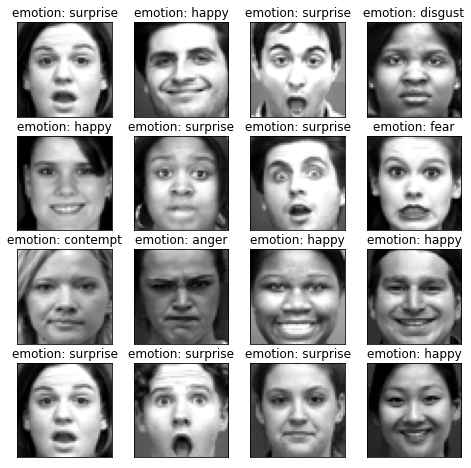

In [ ]:
rcParams['figure.figsize'] = 8, 8
fig, axs = plt.subplots(4, 4)

for i in range(4):
  for j in range(4):
    index = random.randint(0, len(CK48_img_list)-1) #pick a random index
    img = CK48_img_list[index]
    label = CK48_label_list[index]
    axs[i, j].imshow(img, cmap='gray')
    axs[i, j].set_title("emotion: " + label_to_text[label])
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])


**Export the images to the respective emotion subdirectorie in the input folder**

In [ ]:
#for i in range(len(CK48_img_list)):
#  label = CK48_label_list[i]
#  emotion_folder = label_to_text[label]
#  img = Image.fromarray(CK48_img_list[i])
#  img.save(folder_compiled_dataset + emotion_folder + "/ck48_" + str(i) + ".jpeg")

## JAFFE

**Read data**

In [ ]:
folder_jaffe = 'drive/My Drive/Colab Notebooks/Data/JAFFE/jaffedbase/'
folder_jaffe_xlsx = 'drive/My Drive/Colab Notebooks/Data/JAFFE/jaffedbase_readme.xlsx'

**Import JAFFE readme file, which will allow to identify which pictures should be kept**

In [ ]:
# import jaffe readme xlsx file
jaffe_readme = pd.read_excel(folder_jaffe_xlsx)

# drop file index column
jaffe_readme.drop('idx', axis=1, inplace = True)

# check data
jaffe_readme.head()

HAP   SAD   SUR   ANG   DIS   FEA     PIC
0  2.87  2.52  2.10  1.97  1.97  2.06  KM-NE1
1  2.87  2.42  1.58  1.84  1.77  1.77  KM-NE2
2  2.50  2.10  1.70  1.50  1.73  1.53  KM-NE3
3  4.90  1.13  1.26  1.10  1.03  1.10  KM-HA1
4  4.87  1.20  1.43  1.03  1.07  1.07  KM-HA2

**Transform data in order to find out which picture has the highest score for each**

In [ ]:
# split the pic identification by separator '-' into the person_id
jaffe_readme['person_id'] = [x[0] for x in jaffe_readme['PIC'].str.split('-')]

#... and emotion_id (without the number that follows the emotion)
jaffe_readme['emotion_id'] = [re.sub('[1-9]', '', x[1]) for x in jaffe_readme['PIC'].str.split('-')]

# replace '-' by '.' in the PIC column in order to align this column with the names used in the pictures
jaffe_readme['PIC'] = jaffe_readme['PIC'].str.replace('-','.')

We noticed that the PIC file TM.HA4 doesn't exist. Since this id records the maximum value for the person TM and emotion Happy, we excluded this record from the readme file and therefore the second maximum will be gather.

In [ ]:
jaffe_readme = jaffe_readme.drop(jaffe_readme[jaffe_readme['PIC']=='TM.HA4'].index)
jaffe_readme.shape

In [ ]:
# identify the PIC which records the maximum of the emotions scores grouped by person and emotion id
jaffe_readme_emotion = jaffe_readme

# find row wise max value
jaffe_readme_emotion['emotion_max'] = jaffe_readme[['HAP','SAD','SUR','ANG','DIS','FEA']].max(axis=1)

# filter rows from groups
jaffe_readme_emotion = jaffe_readme_emotion.loc[jaffe_readme_emotion.groupby(['person_id','emotion_id'])['emotion_max'].idxmax()]

jaffe_readme_emotion.shape

(71, 10)

**Read the images and labels and store them in lists**

In [ ]:
#Load the images and labels
def get_label_from_filename(filename):
  """ Given a filename of the format 'NM.NE2.93.tiff', return the label 'NE'."""
  index = filename.find('.')
  return filename[index+1:index+3]

emotion_to_int =  {"SU":0, "SA":1, "HA":2, "FE":3, "DI":4, "CO":5, "AN":6, "NE":7}
int_to_emotion =  label_to_text

jaffe_img_list = []
jaffe_label_list = []

for img in os.listdir(folder_jaffe):
  if "tiff" not in img: #process only img files
    continue
  if img.rsplit('.', 2)[0] in jaffe_readme_emotion['PIC'].tolist():  
      #read the image
      input_img = cv2.imread(folder_jaffe + "/" + img, cv2.IMREAD_GRAYSCALE)
      input_img_resize = cv2.resize(input_img,(48,48))
      jaffe_img_list.append(input_img_resize)

      #read the label
      emotion = get_label_from_filename(img) #label: AN, CO, DI, FE, NE, SA, SU, HA
      emotion_int = emotion_to_int[emotion]  #convert label to number 0-6
      jaffe_label_list.append(emotion_int)
  else:
    continue

print(f"Dataset with {len(jaffe_img_list)} pictures.")
print(f"Dataset with {len(jaffe_label_list)} pictures.")


Dataset with 70 pictures.
Dataset with 70 pictures.


**Visualize a random sample of images**

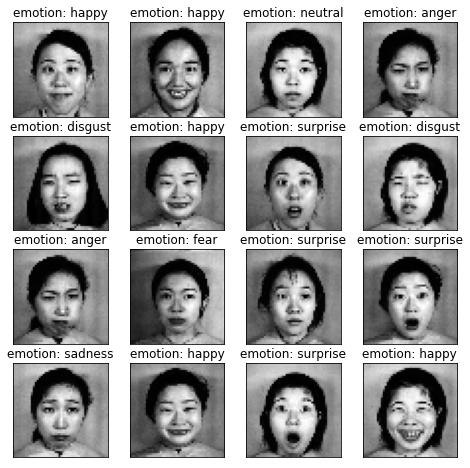

In [ ]:
rcParams['figure.figsize'] = 8, 8
fig, axs = plt.subplots(4, 4)

for i in range(4):
  for j in range(4):
    index = random.randint(0, len(jaffe_img_list)-1) # pick a random index
    img = jaffe_img_list[index]
    label = jaffe_label_list[index]
    axs[i, j].imshow(img, cmap='gray')
    axs[i, j].set_title("emotion: " + int_to_emotion[label])
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])

**Export the images to the respective emotion subdirectorie in the input folder**

In [ ]:
#for i in range(len(jaffe_img_list)):
#  label = jaffe_label_list[i]
#  emotion_folder = int_to_emotion[label]
#  img = Image.fromarray(jaffe_img_list[i])
#  img.save(folder_compiled_dataset + emotion_folder + "/jaffe" + str(i) + ".jpeg")

## SFEW



**Read data**

In [ ]:
folder_sfew = 'drive/My Drive/Colab Notebooks/Data/SFEW/'

In [ ]:
with open(folder_sfew + 'SFEW.pckl', 'rb') as f:
  sfew = pickle.load(f)

**Read the images and labels and store them in lists**

In [ ]:
#reshapping SFEW images
sfew_img_list = []
for img in sfew[0]:
  img_resize = cv2.resize(img,(48,48))
  sfew_img_list.append(img_resize)

#same labeling as previous datasets
sfew_label_list = []
for label in sfew[3]:
  if label==0: sfew_label_list.append(6)
  elif label==1: sfew_label_list.append(4)
  elif label==2: sfew_label_list.append(3)
  elif label==3: sfew_label_list.append(2)
  elif label==4: sfew_label_list.append(7)
  elif label==5: sfew_label_list.append(1)
  elif label==6: sfew_label_list.append(0)

print(f"Dataset with {len(sfew_img_list)} pictures.")
print(f"Dataset with {len(sfew_label_list)} labels.")

Dataset with 1322 pictures.
Dataset with 1322 labels.


**Visualize a random sample of images**

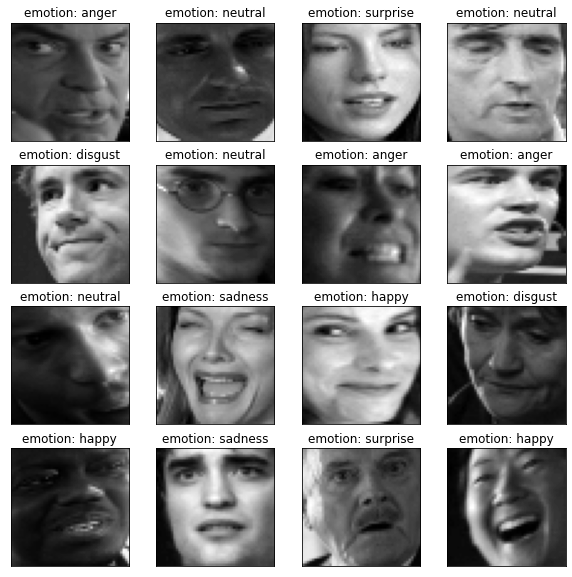

In [ ]:
#Plot a random sample of images
rcParams['figure.figsize'] = 10, 10
fig, axs = plt.subplots(4, 4)

#index=700
for i in range(4):
  for j in range(4):
    index = random.randint(0, len(sfew_img_list)-1) #pick a random index
    img = sfew_img_list[index]
    label = sfew_label_list[index]
    axs[i, j].imshow(img, cmap='gray')
    axs[i, j].set_title("emotion: " + int_to_emotion[label])
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    #index += 1

**note that this dataset has some noisy pictures**

**Export the images to the respective emotion subdirectorie in the input folder**

In [ ]:
#for i in range(len(sfew_img_list)):
#  label = sfew_label_list[i]
#  emotion_folder = int_to_emotion[label]
#  img = Image.fromarray(sfew_img_list[i])
#  img.save(folder_compiled_dataset + emotion_folder + "/sfew" + str(i) + ".jpeg")

**------->    Manually delete noisy pictures from input directory**


In [ ]:
total_images_count = 0
for emotion in os.listdir(folder_compiled_dataset):
  total_images_count += len(os.listdir(folder_compiled_dataset + emotion))
  print(f'{emotion}: {len(os.listdir(folder_compiled_dataset + emotion))} pictures')
print('\n')
print(f'There is a total of {total_images_count} pictures.')

surprise: 233 pictures
sadness: 252 pictures
happy: 315 pictures
fear: 156 pictures
disgust: 141 pictures
anger: 293 pictures
neutral: 232 pictures


There is a total of 1622 pictures.


**remove contempt directory**

In [ ]:
#shutil.rmtree(folder_compiled_dataset + 'contempt')

In [ ]:
# create a new emotions list without contempt 
emotions_final = [x for x in EMOTIONS if x != 'contempt']

# create a list with the indexes of the previous list
emotions_index_final = [emotions_final.index(x) for x in emotions_final]

# create dictionaries 
emotion_to_int_final = dict(zip(emotions_final, emotions_index_final))
int_to_emotion_final = dict((v,k) for k,v in emotion_to_int_final.items())

## Compiled dataset


Create the new lists to save the images and labels and a new dictionary with the mapping between emotion and numeric value (and vv)

In [ ]:
dataset_img_list = []
dataset_label_list = []

for emotion in os.listdir(folder_compiled_dataset):
  for f in os.listdir(folder_compiled_dataset + emotion):
    input_img = cv2.imread(folder_compiled_dataset + emotion + "/" + f, cv2.IMREAD_GRAYSCALE)
    dataset_img_list.append(input_img)
    dataset_label_list.append(emotion_to_int_final[emotion])

print(f'The merged dataset has {len(dataset_img_list)} pictures and {len(dataset_label_list)} labels.')

The merged dataset has 1622 pictures and 1622 labels.


**Count the number of images by emotion**

In [ ]:
for i in set(dataset_label_list): 
  print(f'There are {dataset_label_list.count(i)} {int_to_emotion_final[i]} pictures.')
print(f'\nThere is a total of {len(dataset_img_list)} pictures.')

There are 233 surprise pictures.
There are 252 sadness pictures.
There are 315 happy pictures.
There are 156 fear pictures.
There are 141 disgust pictures.
There are 293 anger pictures.
There are 232 neutral pictures.

There is a total of 1622 pictures.


**Visualize a random sample of images**

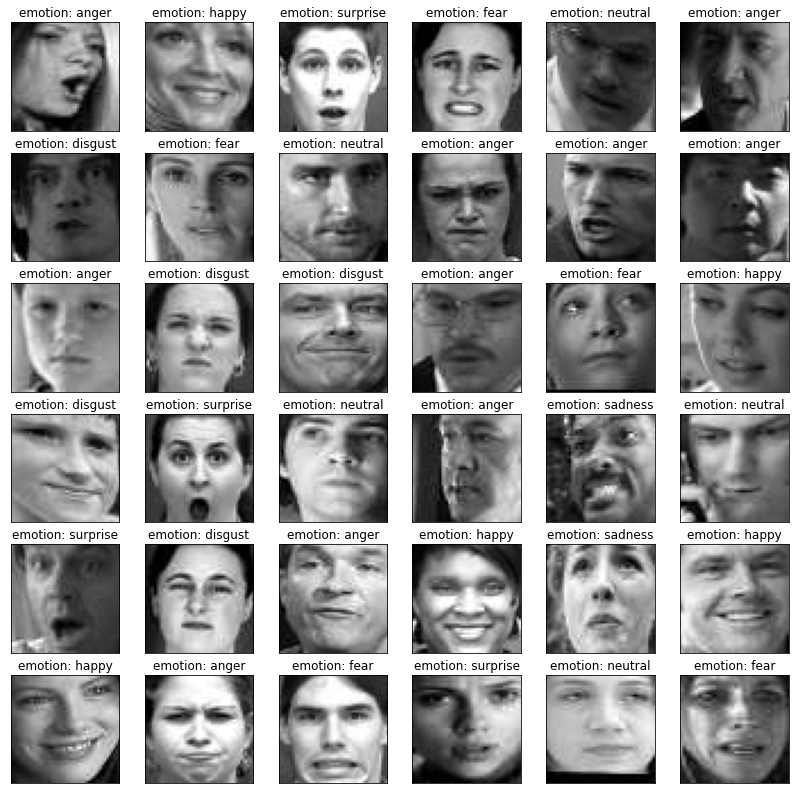

In [ ]:
#Plot a random sample of images
rcParams['figure.figsize'] = 14, 14
fig, axs = plt.subplots(6, 6)

#index=700
for i in range(6):
  for j in range(6):
    index = random.randint(0, len(dataset_img_list)-1) #pick a random index
    img = dataset_img_list[index]
    label = dataset_label_list[index]
    axs[i, j].imshow(img.reshape(48,48), cmap='gray')
    axs[i, j].set_title("emotion: " + int_to_emotion_final[label])
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    #index += 1

## Train, Validation and Test datasets

This code uses the train_test_split function from scikit-learn to split a dataset of images (stored in the variable "img_arr") and their labels (stored in the variable "img_label") into training and testing sets. The function takes several parameters:

The first parameter is the input dataset, in this case "img_arr".
The second parameter is the input labels, in this case "img_label".
The "train_size" parameter is set to 0.7, meaning that 70% of the data will be used for training and the remaining 30% will be used for testing.
The "stratify" parameter is set to "img_label", meaning that the split will be made so that the proportion of classes in both training and testing sets are the same as in the original dataset.
The "shuffle" parameter is set to True, meaning that the data will be shuffled before the split to prevent any bias.
The "random_state" parameter is set to 42, meaning that the random number generator will be initialized with 42, which will make the result of the split reproducible.
The final two lines of code prints the shape of training and test set, respectively.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset_img_list, dataset_label_list, train_size=0.85, stratify=dataset_label_list, shuffle=True, random_state=seed)
len(X_train), len(X_test)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.85, stratify=y_train, shuffle=True, random_state=seed)
len(X_train), len(X_val)

## Balance Train dataset: image data augmentation

Image data augmentation involves creating transformed versions of images in the training dataset that belong to the same class as the original image.
Examples of transformations are shifts, flips, zooms, etc. The intent is to expand the training dataset with new, plausible examples.

For example, a horizontal flip of a picture of a person may make sense, because the photo could have been taken from the left or right. A vertical flip of the photo of a person does not make sense and would probably not be appropriate given that the model is very unlikely to see a photo of an upside down person.

**Create a train, train with image augmentation and test folders and subdirectories for each emotion**

In [ ]:
folder_input = 'drive/My Drive/Colab Notebooks/Data/Input/'

In [ ]:
for folder in ['TRAIN_augmentation', 'TRAIN', 'VALIDATION', 'TEST']:
  for emotion in emotions_final:
    os.makedirs(folder_input + folder + '/' + emotion, exist_ok=True)
    #print('Created:',folder_input + folder + '/' + emotion)

**Split the TRAIN images according to the respective emotion.**

In [ ]:
#for i in range(len(X_train)):
#  label = y_train[i]
#  emotion_folder = int_to_emotion_final[label]
#  img = Image.fromarray(X_train[i])
#  img.save(folder_input + 'TRAIN/' + emotion_folder + '/TRAIN_' + str(i+1) + '.jpeg')

**Split the VALIDATION images according to the respective emotion.**

In [ ]:
#for i in range(len(X_val)):
#  label = y_val[i]
#  emotion_folder = int_to_emotion_final[label]
#  img = Image.fromarray(X_val[i])
#  img.save(folder_input + 'VALIDATION/' + emotion_folder + '/VALIDATION_' + str(i+1) + '.jpeg')

**Split the TEST images according to the respective emotion.**

In [ ]:
#for i in range(len(X_test)):
#  label = y_test[i]
#  emotion_folder = int_to_emotion_final[label]
#  img = Image.fromarray(X_test[i])
#  img.save(folder_input +  'TEST/' + emotion_folder + '/TEST_' + str(i+1) + '.jpeg')

**Create a dictionary to know how many pictures we need to generate using data augmentation**

In [ ]:
aux_list = []
aux_list_index = []

aux_dict = {}
aux_dict_aug = {}

for dir_ in os.listdir(folder_input + 'TRAIN/'):
    count = 0
    for f in os.listdir(folder_input + 'TRAIN/' + dir_ + "/"):
        count += 1
    aux_list.append(count)
    aux_list_index.append(dir_)
  
aux_dict = dict(zip(aux_list_index, aux_list))

target_label = max(aux_dict, key=aux_dict.get)
target = max(aux_dict.values())

aux_dict_aug = {k: target - v for k, v in aux_dict.items()}

print(f'The emotion {target_label} has the highest number of pictures: {target}.')

The emotion happy has the highest number of pictures: 228.


In [ ]:
for key, value in aux_dict_aug.items():
  print(f'For {key} we need to generate: {value} augmented pictures.')

For surprise we need to generate: 60 augmented pictures.
For sadness we need to generate: 46 augmented pictures.
For happy we need to generate: 0 augmented pictures.
For fear we need to generate: 116 augmented pictures.
For disgust we need to generate: 126 augmented pictures.
For anger we need to generate: 16 augmented pictures.
For neutral we need to generate: 61 augmented pictures.


In [ ]:
# create augmented image generator --- explore why we are giving these arg
imggen = ImageDataGenerator(
    rotation_range=15,      #rotate images through any degree between 0 and 360
    width_shift_range=0.15, #horizontal shift of image (% of width of the image to shift)
    height_shift_range=0.15,#vertical shift of image (% of height of the image to shift)
    shear_range=0.15,       #applying shearing transformations: e.g. takes any point with coordinates (x,y) to the point (x+2y,y)
    zoom_range=0.15,        #if specified a float value, then zoom will be done in the range [1-zoom_range,1+zoom_range]
    #brightness_range=[0.2,1], #picks a brightness shift value from that range. Values less than 1.0 darkens the image, whereas values above 1.0 brighten the image.
    horizontal_flip=True)   #flipping along the horizontal axis
#imggen.fit(X_train)

In [ ]:
for emotion in os.listdir(folder_input + 'TRAIN/'):

  #folder size identifies how many files exist in each emotion folder
  emotion_folder_size = len(os.listdir(folder_input + 'TRAIN/' + emotion)) 
  
  #for each emotion we will consult the aux_dict_aug dictionary to know how many pictures we need to generate
  for i in range(aux_dict_aug[emotion]): 
    #generate random index and save the correspondent image in the input_img list
    index_aux = random.randint(0, emotion_folder_size-1)
    input_img = cv2.imread(folder_input + 'TRAIN/' + emotion + '/' + os.listdir(folder_input + 'TRAIN/' + emotion)[index_aux])

    #apply the augmented image generator to the image
    aug_img_iterator = imggen.flow(x=np.expand_dims(input_img,0), batch_size=1)
    aug_img=next(aug_img_iterator)

    # save the augmented image
    #cv2.imwrite(folder_input + r'TRAIN_augmentation/' + emotion + '/aug_img_' + str(i+1) + '.jpeg', aug_img[0,:,:,:])

In [ ]:
total_images_count = 0
for emotion in os.listdir(folder_input + 'TRAIN_augmentation/'):
  print(f'For {emotion} {len(os.listdir(folder_input + "TRAIN_augmentation/" + emotion))} pictures were generated from data augmentation.')
  total_images_count += len(os.listdir(folder_input + r'TRAIN_augmentation/' + emotion))
print(f'\nThere is a total of {total_images_count} pictures.')

For surprise 228 pictures were generated from data augmentation.
For sadness 228 pictures were generated from data augmentation.
For happy 228 pictures were generated from data augmentation.
For fear 228 pictures were generated from data augmentation.
For disgust 228 pictures were generated from data augmentation.
For anger 228 pictures were generated from data augmentation.
For neutral 228 pictures were generated from data augmentation.

There is a total of 1596 pictures.


**Visualize the augmented pictures**

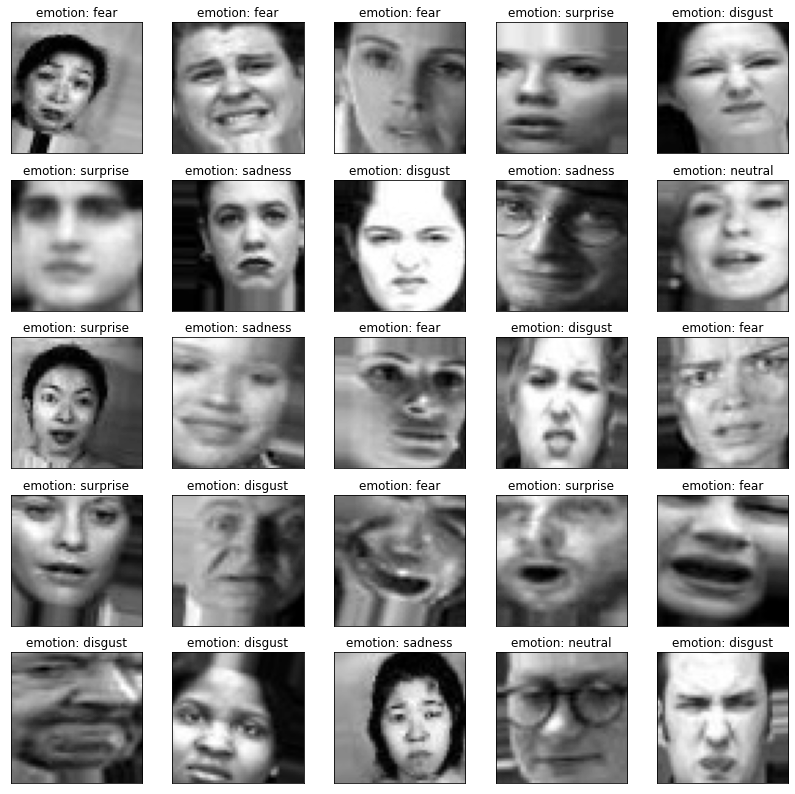

In [ ]:
#Plot a random sample of images
rcParams['figure.figsize'] = 14, 14
fig, axs = plt.subplots(5, 5)

aug_img_plt = []
aug_img_lbl_plt = []

for emotion in os.listdir(folder_input + 'TRAIN_augmentation/'):
  for pic in os.listdir(folder_input + 'TRAIN_augmentation/' + emotion):
    if 'aug_img' in pic: 
      aug_img_plt.append(cv2.imread(folder_input + 'TRAIN_augmentation/' + emotion + '/' + pic,cv2.IMREAD_GRAYSCALE))
      aug_img_lbl_plt.append(emotion)
  
  #for each emotion we will consult the aux_dict_aug dictionary to know how many pictures we need to generate
  for i in range(5): 
    for j in range(5):
    #generate random index and save the correspondent image in the input_img list
      index_aux = random.randint(0, len(aug_img_plt)-1)
      img = aug_img_plt[index_aux]
      label = aug_img_lbl_plt[index_aux]
      axs[i, j].imshow(img.reshape(48,48), cmap='gray')
      axs[i, j].set_title("emotion: " + label)
      axs[i, j].set_xticks([])
      axs[i, j].set_yticks([])
      #index += 1

**Copy the pictures from TRAIN folder to TRAIN_augmentation folder**

In [ ]:
#for emotion in os.listdir(folder_input + 'TRAIN/'):
#  for f in os.listdir(folder_input + 'TRAIN/' + emotion):
#    shutil.copy(folder_input + 'TRAIN/' + emotion + '/' + f,
#                folder_input + 'TRAIN_augmentation/' + emotion + '/' + f)

## Train, validation and test datasets normalization

**Import train, validation and test datasets**

In [ ]:
# create a new emotions list without contempt 
emotions_final = [x for x in EMOTIONS if x != 'contempt']

# create a list with the indexes of the previous list
emotions_index_final = [emotions_final.index(x) for x in emotions_final]

# create dictionaries 
emotion_to_int_final = dict(zip(emotions_final, emotions_index_final))
int_to_emotion_final = dict((v,k) for k,v in emotion_to_int_final.items())

In [ ]:
emotion_to_int_final

{'surprise': 0,
 'sadness': 1,
 'happy': 2,
 'fear': 3,
 'disgust': 4,
 'anger': 5,
 'neutral': 6}

In [ ]:
X_train_list = []
y_train_list = []

for emotion in os.listdir(folder_input + 'TRAIN/'):
  for pic in os.listdir(folder_input + 'TRAIN/' + emotion):
    X_train_list.append(cv2.imread(folder_input + 'TRAIN/' + emotion + '/' + pic))
    y_train_list.append(emotion_to_int_final[emotion])

len(X_train_list), len(y_train_list)

(1171, 1171)

In [ ]:
X_train_bal_list = []
y_train_bal_list = []

for emotion in os.listdir(folder_input + 'TRAIN_augmentation/'):
  for pic in os.listdir(folder_input + 'TRAIN_augmentation/' + emotion):
    X_train_bal_list.append(cv2.imread(folder_input + 'TRAIN_augmentation/' + emotion + '/' + pic))
    y_train_bal_list.append(emotion_to_int_final[emotion])

len(X_train_bal_list), len(y_train_bal_list)

(1596, 1596)

In [ ]:
X_val_list = []
y_val_list = []

for emotion in os.listdir(folder_input + 'VALIDATION/'):
  for pic in os.listdir(folder_input + 'VALIDATION/' + emotion):
    X_val_list.append(cv2.imread(folder_input + 'VALIDATION/' + emotion + '/' + pic))
    y_val_list.append(emotion_to_int_final[emotion])

len(X_val_list), len(y_val_list)

(207, 207)

In [ ]:
X_test_list = []
y_test_list = []

for emotion in os.listdir(folder_input + 'TEST/'):
  for pic in os.listdir(folder_input + 'TEST/' + emotion):
    X_test_list.append(cv2.imread(folder_input + 'TEST/' + emotion + '/' + pic))
    y_test_list.append(emotion_to_int_final[emotion])

len(X_test_list), len(y_test_list)

(244, 244)

**Image and labels transformation to be used as input to CNNs for train, validation and test datasets**

In [ ]:
X_train = np.array(X_train_list) #create an array with the merged dataset list
X_train = X_train.astype('float32') #format the values to float32 type
X_train = X_train / 255 #normalizes the values between 0 and 1
labels_numeric_train = np.array(y_train_list) #create labels array
y_train = to_categorical(labels_numeric_train, num_classes = len(set(labels_numeric_train)))

In [ ]:
X_train_bal = np.array(X_train_bal_list) #create an array with the merged dataset list
X_train_bal = X_train_bal.astype('float32') #format the values to float32 type
X_train_bal = X_train_bal / 255 #normalizes the values between 0 and 1
labels_numeric_bal = np.array(y_train_bal_list) #create labels array
y_train_bal = to_categorical(labels_numeric_bal, num_classes = len(set(labels_numeric_bal)))

In [ ]:
X_val = np.array(X_val_list) #create an array with the merged dataset list
X_val = X_val.astype('float32') #format the values to float32 type
X_val = X_val / 255 #normalizes the values between 0 and 1
labels_numeric_val = np.array(y_val_list) #create labels array
y_val = to_categorical(labels_numeric_val, num_classes = len(set(labels_numeric_val)))

In [ ]:
X_test = np.array(X_test_list) #create an array with the merged dataset list
X_test = X_test.astype('float32') #format the values to float32 type
X_test = X_test / 255 #normalizes the values between 0 and 1
labels_numeric_test = np.array(y_test_list) #create labels array
y_test = to_categorical(labels_numeric_test, num_classes = len(set(labels_numeric_test)))

# Set parameters
Using the same CNN architecture, vary bach size and learning rate, to select the most suitable configuration

## Learning rate

### 0.01

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn00'
if del_var in globals(): globals().pop(del_var, None)

cnn00 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn00.build(X_train.shape)
# Check network
cnn00.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (1171, 46, 46, 32)        896       
                                                                 
 activation_4 (Activation)   (1171, 46, 46, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (1171, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (1171, 21, 21, 64)        18496     
                                                                 
 activation_5 (Activation)   (1171, 21, 21, 64)        0         
                                                                 
 global_max_pooling2d_2 (Glo  (1171, 64)               0         
 balMaxPooling2D)                                     

In [ ]:
learning_rate = 0.01
cnn00.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history = cnn00.fit(X_train, y_train, batch_size=32,epochs=100, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

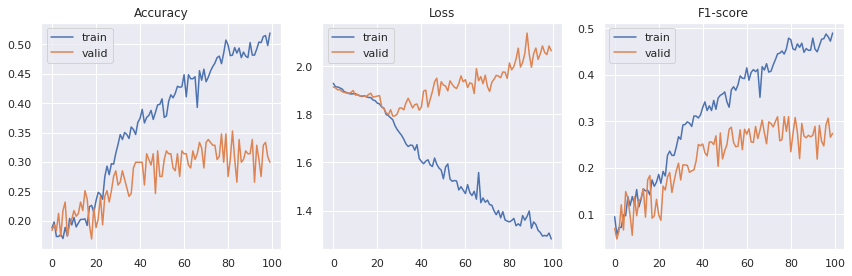

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history.epoch, history.history['f1_score'], label='train')
sns.lineplot(history.epoch, history.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

### 0.001

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn00'
if del_var in globals(): globals().pop(del_var, None)

cnn00 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn00.build(X_train.shape)
# Check network
cnn00.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (1171, 46, 46, 32)        896       
                                                                 
 activation_12 (Activation)  (1171, 46, 46, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (1171, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (1171, 21, 21, 64)        18496     
                                                                 
 activation_13 (Activation)  (1171, 21, 21, 64)        0         
                                                                 
 global_max_pooling2d_6 (Glo  (1171, 64)               0         
 balMaxPooling2D)                                     

In [ ]:
learning_rate = 0.001
cnn00.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history = cnn00.fit(X_train, y_train, batch_size=32,epochs=100, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

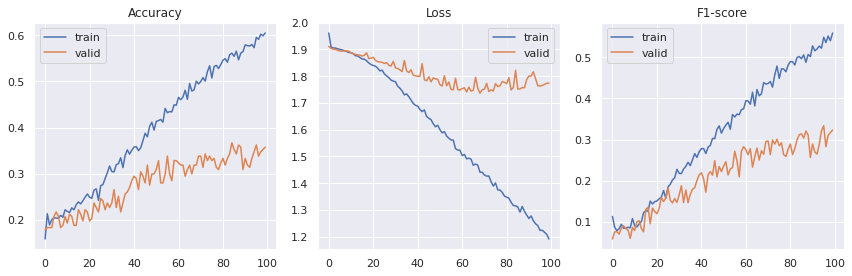

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history.epoch, history.history['f1_score'], label='train')
sns.lineplot(history.epoch, history.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

### 0.0001

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn00'
if del_var in globals(): globals().pop(del_var, None)

cnn00 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn00.build(X_train.shape)
# Check network
cnn00.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (1171, 46, 46, 32)        896       
                                                                 
 activation_8 (Activation)   (1171, 46, 46, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (1171, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (1171, 21, 21, 64)        18496     
                                                                 
 activation_9 (Activation)   (1171, 21, 21, 64)        0         
                                                                 
 global_max_pooling2d_4 (Glo  (1171, 64)               0         
 balMaxPooling2D)                                     

In [ ]:
learning_rate = 0.0001
cnn00.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history = cnn00.fit(X_train, y_train, batch_size=32,epochs=100, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

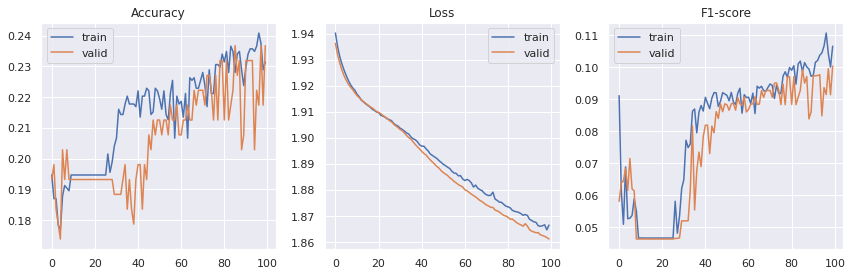

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history.epoch, history.history['f1_score'], label='train')
sns.lineplot(history.epoch, history.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

## Batch size

### 32
Already executed (refer to Learning rate 0.001)

### 64

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn00'
if del_var in globals(): globals().pop(del_var, None)

cnn00 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn00.build(X_train.shape)
# Check network
cnn00.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (1171, 46, 46, 32)        896       
                                                                 
 activation_10 (Activation)  (1171, 46, 46, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (1171, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (1171, 21, 21, 64)        18496     
                                                                 
 activation_11 (Activation)  (1171, 21, 21, 64)        0         
                                                                 
 global_max_pooling2d_5 (Glo  (1171, 64)               0         
 balMaxPooling2D)                                     

In [ ]:
learning_rate = 0.001
cnn00.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history = cnn00.fit(X_train, y_train, batch_size=64,epochs=100, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

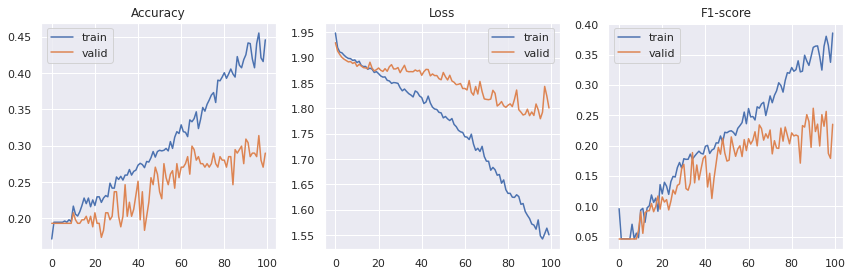

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history.epoch, history.history['f1_score'], label='train')
sns.lineplot(history.epoch, history.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

### 128

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn00'
if del_var in globals(): globals().pop(del_var, None)

cnn00 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn00.build(X_train.shape)
# Check network
cnn00.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (1171, 46, 46, 32)        896       
                                                                 
 activation_14 (Activation)  (1171, 46, 46, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (1171, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (1171, 21, 21, 64)        18496     
                                                                 
 activation_15 (Activation)  (1171, 21, 21, 64)        0         
                                                                 
 global_max_pooling2d_7 (Glo  (1171, 64)               0         
 balMaxPooling2D)                                     

In [ ]:
learning_rate = 0.001
cnn00.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history = cnn00.fit(X_train, y_train, batch_size=128,epochs=100, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

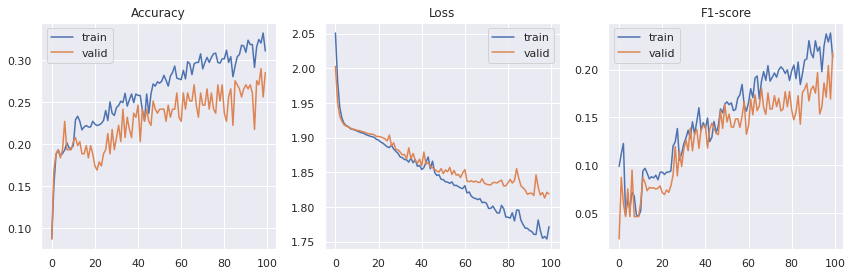

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history.epoch, history.history['f1_score'], label='train')
sns.lineplot(history.epoch, history.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

## Selected parameters
- Learning rate: 0.001
- Batch_size=32

# Candidate models


### Iteration 1 - Training dataset (balanced vs unbalanced)

#### CNN-11 - Baseline model, unbalanced classes



##### 200 epochs

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn11'
if del_var in globals(): globals().pop(del_var, None)

cnn11 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn11.build(X_train.shape)
# Check network
cnn11.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (1171, 46, 46, 32)        896       
                                                                 
 activation_16 (Activation)  (1171, 46, 46, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (1171, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (1171, 21, 21, 64)        18496     
                                                                 
 activation_17 (Activation)  (1171, 21, 21, 64)        0         
                                                                 
 global_max_pooling2d_8 (Glo  (1171, 64)               0         
 balMaxPooling2D)                                     

In [ ]:
learning_rate = 0.001
cnn11.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history11 = cnn11.fit(X_train, y_train, batch_size=32,epochs=200, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

In [ ]:
!tensorboard dev upload --logdir logs --name "CNN11" --description "CNN11"

2023-02-01 13:24:42.748230: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

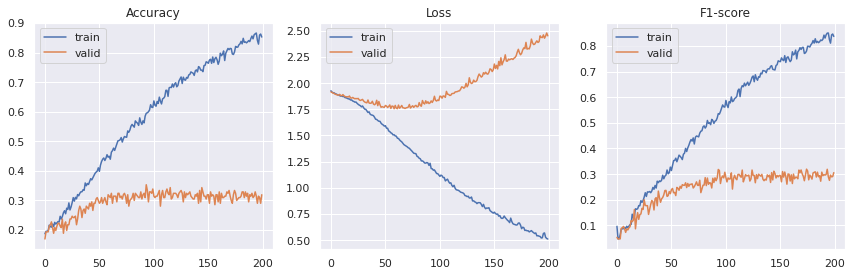

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history11.epoch, history11.history['accuracy'], label='train')
sns.lineplot(history11.epoch, history11.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history11.epoch, history11.history['loss'], label='train')
sns.lineplot(history11.epoch, history11.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history11.epoch, history11.history['f1_score'], label='train')
sns.lineplot(history11.epoch, history11.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

##### 50 epochs

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (1171, 46, 46, 32)        896       
                                                                 
 activation_18 (Activation)  (1171, 46, 46, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (1171, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (1171, 21, 21, 64)        18496     
                                                                 
 activation_19 (Activation)  (1171, 21, 21, 64)        0         
                                                                 
 global_max_pooling2d_9 (Glo  (1171, 64)               0         
 balMaxPooling2D)                                     

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

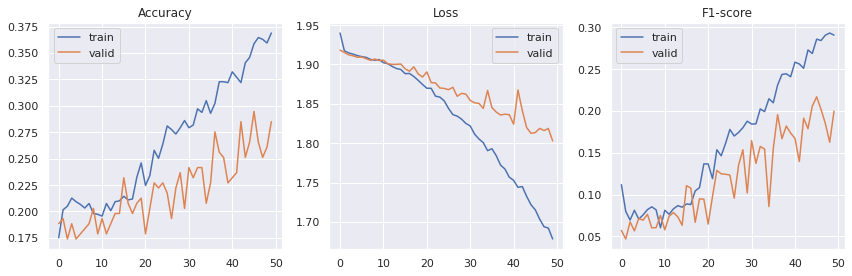

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn11'
if del_var in globals(): globals().pop(del_var, None)

cnn11 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn11.build(X_train.shape)
# Check network
cnn11.summary()

learning_rate = 0.001
cnn11.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

history11 = cnn11.fit(X_train, y_train, batch_size=32,epochs=50, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history11.epoch, history11.history['accuracy'], label='train')
sns.lineplot(history11.epoch, history11.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history11.epoch, history11.history['loss'], label='train')
sns.lineplot(history11.epoch, history11.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history11.epoch, history11.history['f1_score'], label='train')
sns.lineplot(history11.epoch, history11.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()


7/7 [==============================] - 0s 25ms/step
val accuracy: 28.5024 %


              precision    recall  f1-score   support

           0       0.37      0.43      0.40        30
           1       0.24      0.38      0.29        32
           2       0.37      0.55      0.44        40
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        18
           5       0.22      0.32      0.26        37
           6       0.00      0.00      0.00        30

    accuracy                           0.29       207
   macro avg       0.17      0.24      0.20       207
weighted avg       0.20      0.29      0.24       207



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


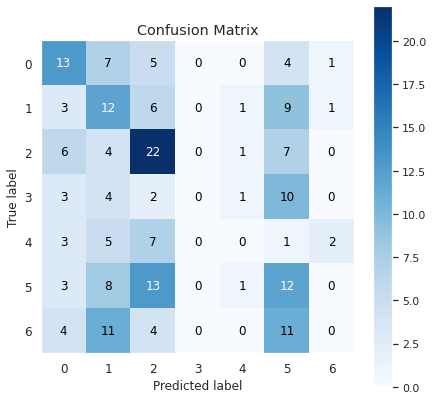

In [ ]:
yp_val = cnn11.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn11.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))


#### CNN-12 - Baseline model, balanced classes

##### 200 epochs

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn12'
if del_var in globals(): globals().pop(del_var, None)

cnn12 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn12.build(X_train_bal.shape)
# Check network
cnn12.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (1596, 46, 46, 32)        896       
                                                                 
 activation_20 (Activation)  (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (1596, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (1596, 21, 21, 64)        18496     
                                                                 
 activation_21 (Activation)  (1596, 21, 21, 64)        0         
                                                                 
 global_max_pooling2d_10 (Gl  (1596, 64)               0         
 obalMaxPooling2D)                                   

In [ ]:
learning_rate = 0.001
cnn12.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history12 = cnn12.fit(X_train_bal, y_train_bal, batch_size=32,epochs=200, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

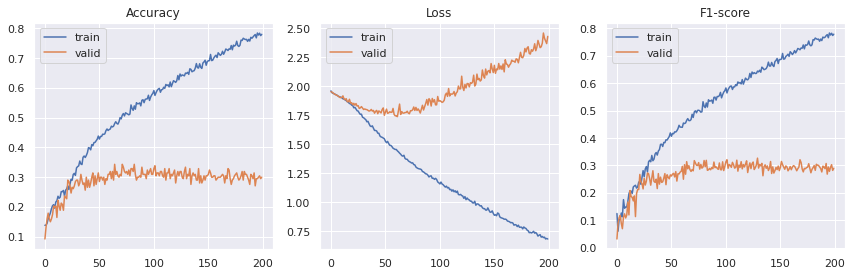

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history12.epoch, history12.history['accuracy'], label='train')
sns.lineplot(history12.epoch, history12.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history12.epoch, history12.history['loss'], label='train')
sns.lineplot(history12.epoch, history12.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history12.epoch, history12.history['f1_score'], label='train')
sns.lineplot(history12.epoch, history12.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

##### 50 epochs

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn12'
if del_var in globals(): globals().pop(del_var, None)

cnn12 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn12.build(X_train_bal.shape)
# Check network
cnn12.summary()


learning_rate = 0.001
cnn12.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])


history12 = cnn12.fit(X_train_bal, y_train_bal, batch_size=32,epochs=50, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (1596, 46, 46, 32)        896       
                                                                 
 activation_26 (Activation)  (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (1596, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (1596, 21, 21, 64)        18496     
                                                                 
 activation_27 (Activation)  (1596, 21, 21, 64)        0         
                                                                 
 global_max_pooling2d_13 (Gl  (1596, 64)               0         
 obalMaxPooling2D)                                   

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

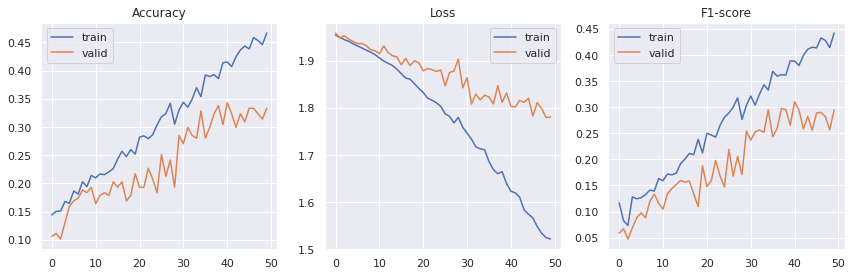

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history12.epoch, history12.history['accuracy'], label='train')
sns.lineplot(history12.epoch, history12.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history12.epoch, history12.history['loss'], label='train')
sns.lineplot(history12.epoch, history12.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history12.epoch, history12.history['f1_score'], label='train')
sns.lineplot(history12.epoch, history12.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 25ms/step
val accuracy: 33.3333 %


              precision    recall  f1-score   support

           0       0.53      0.63      0.58        30
           1       0.27      0.19      0.22        32
           2       0.39      0.55      0.45        40
           3       0.29      0.10      0.15        20
           4       0.20      0.22      0.21        18
           5       0.27      0.11      0.15        37
           6       0.24      0.40      0.30        30

    accuracy                           0.33       207
   macro avg       0.31      0.31      0.29       207
weighted avg       0.32      0.33      0.31       207



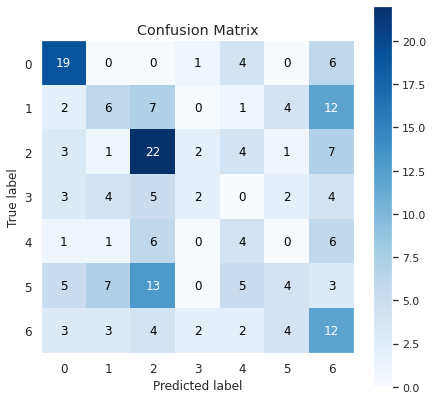

In [ ]:
yp_val = cnn12.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn12.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))


Continuar com modelo 12, F1-Score de treino e validação mais proximos.

## Iteration 2 - Try batch normalization

### CNN-21 At the head of sequential


#### 50 epochs, 32 batch-size

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn21'
if del_var in globals(): globals().pop(del_var, None)

cnn21 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.BatchNormalization(),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn21.build(X_train_bal.shape)
# Check network
cnn21.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (1596, 48, 48, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_12 (Conv2D)          (1596, 46, 46, 32)        896       
                                                                 
 activation_12 (Activation)  (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (1596, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (1596, 21, 21, 64)        18496     
                                                                 
 activation_13 (Activation)  (1596, 21, 21, 64)       

In [ ]:
learning_rate = 0.001
cnn21.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history21 = cnn21.fit(X_train_bal, y_train_bal, batch_size=32,epochs=50, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

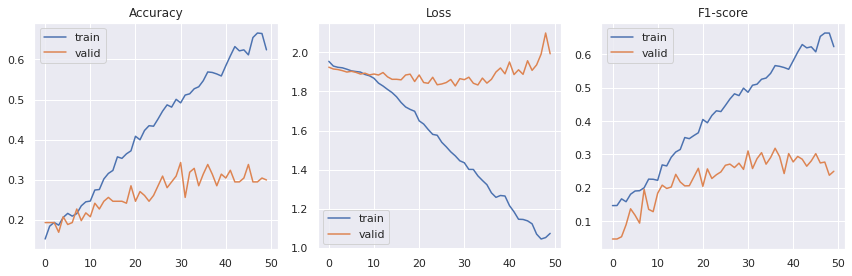

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history21.epoch, history21.history['accuracy'], label='train')
sns.lineplot(history21.epoch, history21.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history21.epoch, history21.history['loss'], label='train')
sns.lineplot(history21.epoch, history21.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history21.epoch, history21.history['f1_score'], label='train')
sns.lineplot(history21.epoch, history21.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 5ms/step
val accuracy: 29.9517 %


              precision    recall  f1-score   support

           0       0.47      0.63      0.54        30
           1       0.30      0.09      0.14        32
           2       0.39      0.60      0.48        40
           3       0.19      0.30      0.23        20
           4       0.17      0.22      0.19        18
           5       0.17      0.16      0.16        37
           6       0.00      0.00      0.00        30

    accuracy                           0.30       207
   macro avg       0.24      0.29      0.25       207
weighted avg       0.25      0.30      0.26       207



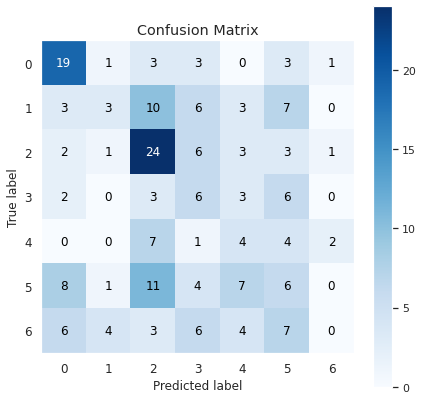

In [ ]:
yp_val = cnn21.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn21.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

#### 50 epochs, 64 batch-size

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn21'
if del_var in globals(): globals().pop(del_var, None)

cnn21 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.BatchNormalization(),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn21.build(X_train_bal.shape)
# Check network
cnn21.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_7 (Batc  (1596, 48, 48, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          (1596, 46, 46, 32)        896       
                                                                 
 activation_14 (Activation)  (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (1596, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (1596, 21, 21, 64)        18496     
                                                                 
 activation_15 (Activation)  (1596, 21, 21, 64)       

In [ ]:
learning_rate = 0.001
cnn21.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history21 = cnn21.fit(X_train_bal, y_train_bal, batch_size=64,epochs=50, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

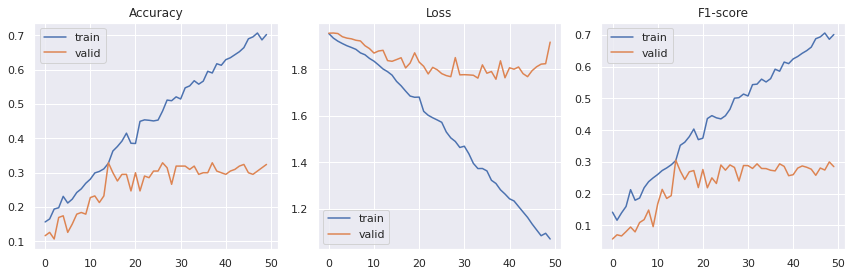

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history21.epoch, history21.history['accuracy'], label='train')
sns.lineplot(history21.epoch, history21.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history21.epoch, history21.history['loss'], label='train')
sns.lineplot(history21.epoch, history21.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history21.epoch, history21.history['f1_score'], label='train')
sns.lineplot(history21.epoch, history21.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 3ms/step
val accuracy: 32.3671 %


              precision    recall  f1-score   support

           0       0.72      0.43      0.54        30
           1       0.25      0.06      0.10        32
           2       0.41      0.72      0.53        40
           3       0.19      0.20      0.20        20
           4       0.06      0.11      0.08        18
           5       0.34      0.27      0.30        37
           6       0.27      0.23      0.25        30

    accuracy                           0.32       207
   macro avg       0.32      0.29      0.28       207
weighted avg       0.35      0.32      0.31       207



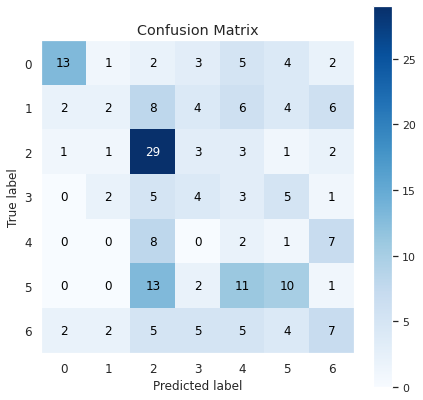

In [ ]:
yp_val = cnn21.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn21.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

#### 50 epochs, 128 batch-size

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn21'
if del_var in globals(): globals().pop(del_var, None)

cnn21 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.BatchNormalization(),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn21.build(X_train_bal.shape)
# Check network
cnn21.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (1596, 48, 48, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (1596, 46, 46, 32)        896       
                                                                 
 activation_4 (Activation)   (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (1596, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (1596, 21, 21, 64)        18496     
                                                                 
 activation_5 (Activation)   (1596, 21, 21, 64)       

In [ ]:
learning_rate = 0.001
cnn21.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history21 = cnn21.fit(X_train_bal, y_train_bal, batch_size=128,epochs=50, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

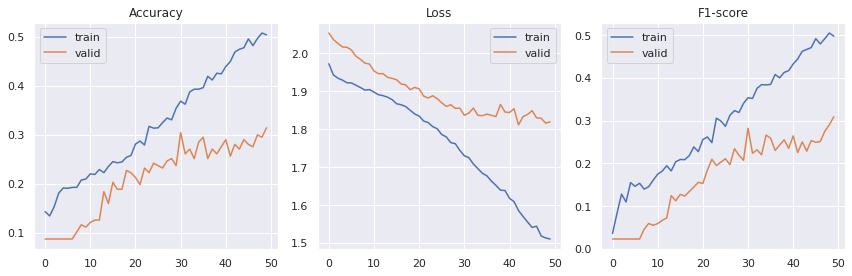

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history21.epoch, history21.history['accuracy'], label='train')
sns.lineplot(history21.epoch, history21.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history21.epoch, history21.history['loss'], label='train')
sns.lineplot(history21.epoch, history21.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history21.epoch, history21.history['f1_score'], label='train')
sns.lineplot(history21.epoch, history21.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 13ms/step
val accuracy: 31.401 %


              precision    recall  f1-score   support

           0       0.60      0.50      0.55        30
           1       0.23      0.22      0.22        32
           2       0.40      0.42      0.41        40
           3       0.36      0.20      0.26        20
           4       0.20      0.33      0.25        18
           5       0.25      0.22      0.23        37
           6       0.23      0.27      0.25        30

    accuracy                           0.31       207
   macro avg       0.32      0.31      0.31       207
weighted avg       0.33      0.31      0.32       207



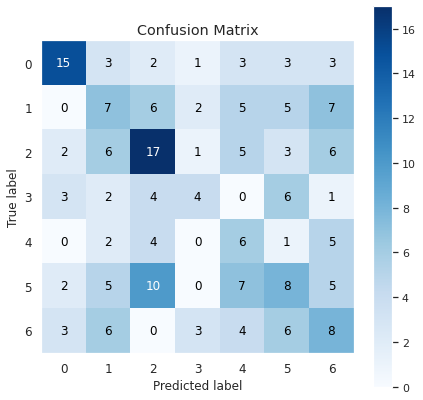

In [ ]:
yp_val = cnn21.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn21.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

### CNN-22 After Convolution layer

#### 50 epochs, 32 batch-size

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn22'
if del_var in globals(): globals().pop(del_var, None)

cnn22 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn22.build(X_train_bal.shape)
# Check network
cnn22.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (1596, 46, 46, 32)        896       
                                                                 
 batch_normalization (BatchN  (1596, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (1596, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (1596, 21, 21, 64)        18496     
                                                                 
 activation_1 (Activation)   (1596, 21, 21, 64)        0

In [ ]:
learning_rate = 0.001
cnn22.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history22 = cnn22.fit(X_train_bal, y_train_bal, batch_size=32,epochs=50, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

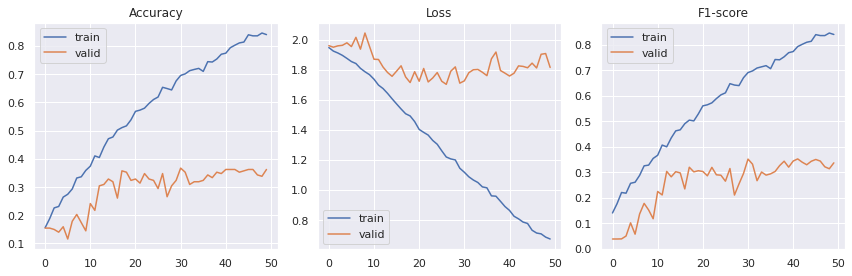

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history22.epoch, history22.history['accuracy'], label='train')
sns.lineplot(history22.epoch, history22.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history22.epoch, history22.history['loss'], label='train')
sns.lineplot(history22.epoch, history22.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history22.epoch, history22.history['f1_score'], label='train')
sns.lineplot(history22.epoch, history22.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 3ms/step
val accuracy: 36.2319 %


              precision    recall  f1-score   support

           0       0.50      0.53      0.52        30
           1       0.42      0.16      0.23        32
           2       0.57      0.42      0.49        40
           3       0.25      0.20      0.22        20
           4       0.28      0.28      0.28        18
           5       0.27      0.59      0.37        37
           6       0.38      0.20      0.26        30

    accuracy                           0.36       207
   macro avg       0.38      0.34      0.34       207
weighted avg       0.40      0.36      0.35       207



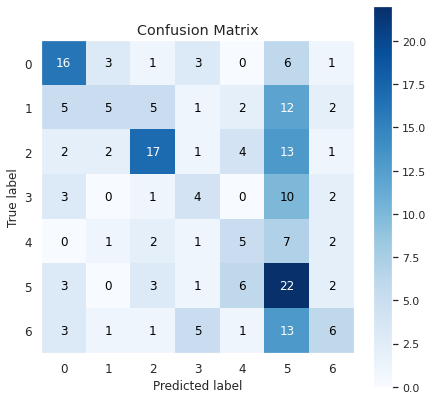

In [ ]:
yp_val = cnn22.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn22.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

#### 50 epochs, 64 batch-size

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn22'
if del_var in globals(): globals().pop(del_var, None)

cnn22 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),

                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn22.build(X_train_bal.shape)
# Check network
cnn22.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (1596, 46, 46, 32)        896       
                                                                 
 batch_normalization_1 (Batc  (1596, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (1596, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (1596, 21, 21, 64)        18496     
                                                                 
 activation_3 (Activation)   (1596, 21, 21, 64)       

In [ ]:
learning_rate = 0.001
cnn22.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history22 = cnn22.fit(X_train_bal, y_train_bal, batch_size=64,epochs=50, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

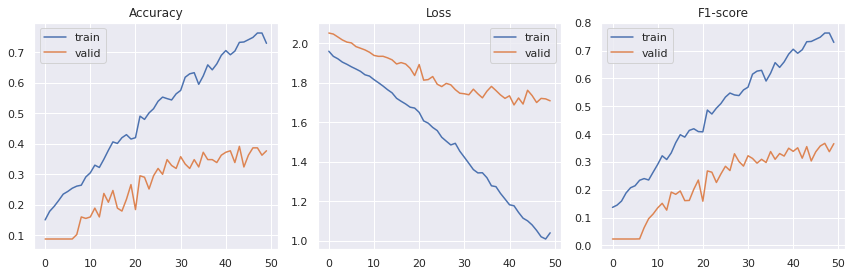

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history22.epoch, history22.history['accuracy'], label='train')
sns.lineplot(history22.epoch, history22.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history22.epoch, history22.history['loss'], label='train')
sns.lineplot(history22.epoch, history22.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history22.epoch, history22.history['f1_score'], label='train')
sns.lineplot(history22.epoch, history22.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 3ms/step
val accuracy: 37.6812 %


              precision    recall  f1-score   support

           0       0.44      0.70      0.54        30
           1       0.27      0.12      0.17        32
           2       0.62      0.38      0.47        40
           3       0.50      0.35      0.41        20
           4       0.29      0.39      0.33        18
           5       0.29      0.41      0.34        37
           6       0.29      0.30      0.30        30

    accuracy                           0.38       207
   macro avg       0.39      0.38      0.37       207
weighted avg       0.39      0.38      0.37       207



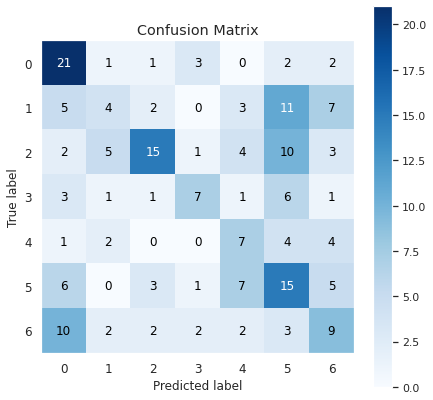

In [ ]:
yp_val = cnn22.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn22.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

#### 50 epochs, 128 batch-size

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn22'
if del_var in globals(): globals().pop(del_var, None)

cnn22 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn22.build(X_train_bal.shape)
# Check network
cnn22.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (1596, 46, 46, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (1596, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (1596, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (1596, 21, 21, 64)        18496     
                                                                 
 activation_9 (Activation)   (1596, 21, 21, 64)       

In [ ]:
learning_rate = 0.001
cnn22.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history22 = cnn22.fit(X_train_bal, y_train_bal, batch_size=128,epochs=50, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

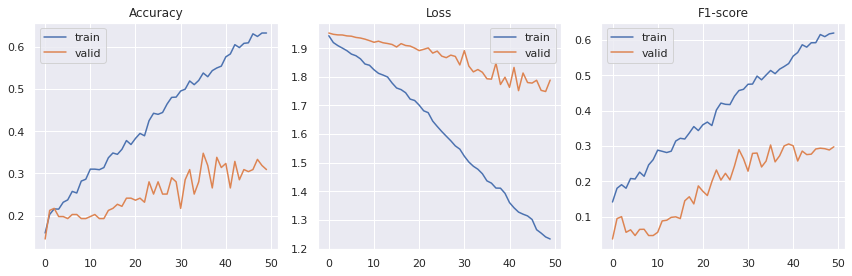

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history22.epoch, history22.history['accuracy'], label='train')
sns.lineplot(history22.epoch, history22.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history22.epoch, history22.history['loss'], label='train')
sns.lineplot(history22.epoch, history22.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history22.epoch, history22.history['f1_score'], label='train')
sns.lineplot(history22.epoch, history22.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 3ms/step
val accuracy: 30.9179 %


              precision    recall  f1-score   support

           0       0.50      0.37      0.42        30
           1       0.20      0.16      0.18        32
           2       0.49      0.55      0.52        40
           3       0.15      0.30      0.20        20
           4       0.27      0.33      0.30        18
           5       0.43      0.16      0.24        37
           6       0.21      0.27      0.24        30

    accuracy                           0.31       207
   macro avg       0.32      0.31      0.30       207
weighted avg       0.34      0.31      0.31       207



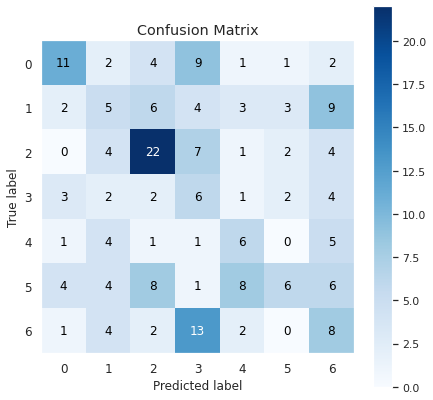

In [ ]:
yp_val = cnn22.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn22.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

## Iteration 3 - Try data augmentation


### CNN-31

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn31'
if del_var in globals(): globals().pop(del_var, None)

cnn31 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   data_augmentation,
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn31.build(X_train_bal.shape)
# Check network
cnn31.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (1596, 48, 48, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (1596, 46, 46, 32)        896       
                                                                 
 batch_normalization_5 (Batc  (1596, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (1596, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (1596, 21, 21, 64)       

In [ ]:
learning_rate = 0.001
cnn31.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

history31 = cnn31.fit(X_train_bal, y_train_bal, batch_size=64,epochs=50, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

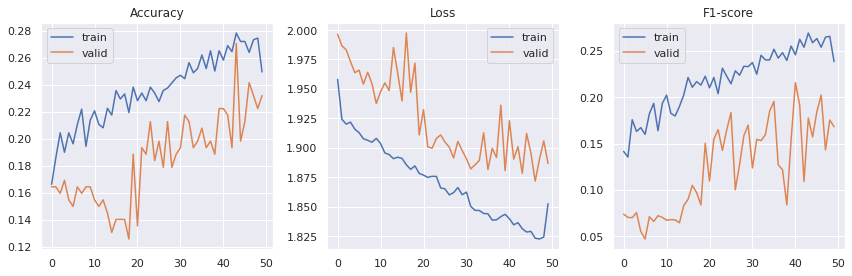

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history31.epoch, history31.history['accuracy'], label='train')
sns.lineplot(history31.epoch, history31.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history31.epoch, history31.history['loss'], label='train')
sns.lineplot(history31.epoch, history31.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history31.epoch, history31.history['f1_score'], label='train')
sns.lineplot(history31.epoch, history31.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 3ms/step
val accuracy: 23.1884 %


              precision    recall  f1-score   support

           0       0.33      0.03      0.06        30
           1       0.00      0.00      0.00        32
           2       0.24      0.68      0.35        40
           3       0.29      0.10      0.15        20
           4       0.11      0.17      0.13        18
           5       0.33      0.14      0.19        37
           6       0.26      0.33      0.29        30

    accuracy                           0.23       207
   macro avg       0.22      0.21      0.17       207
weighted avg       0.23      0.23      0.18       207



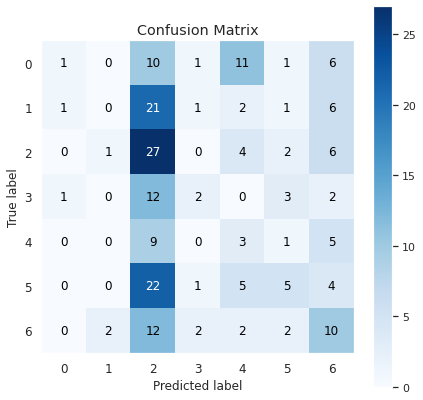

In [ ]:
yp_val = cnn31.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn31.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

## Iteration 4 - Try deeper architectures

### CNN-41 One additional block

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn41'
if del_var in globals(): globals().pop(del_var, None)

cnn41 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),                   
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn41.build(X_train_bal.shape)
# Check network
cnn41.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (1596, 46, 46, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (1596, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_12 (Activation)  (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (1596, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (1596, 21, 21, 64)        18496     
                                                                 
 activation_13 (Activation)  (1596, 21, 21, 64)       

In [ ]:
learning_rate = 0.001
cnn41.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history41 = cnn41.fit(X_train_bal, y_train_bal, batch_size=64,epochs=50, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

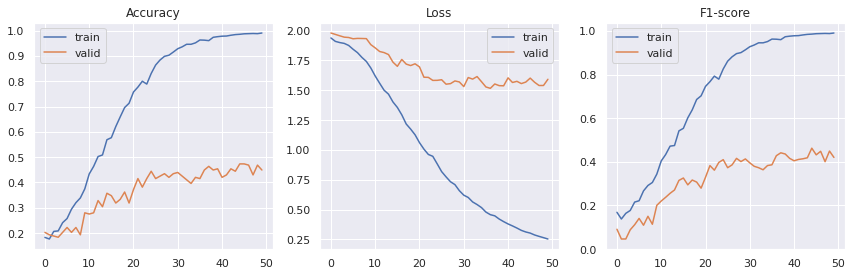

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history41.epoch, history41.history['accuracy'], label='train')
sns.lineplot(history41.epoch, history41.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history41.epoch, history41.history['loss'], label='train')
sns.lineplot(history41.epoch, history41.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history41.epoch, history41.history['f1_score'], label='train')
sns.lineplot(history41.epoch, history41.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 6ms/step
val accuracy: 44.9275 %


              precision    recall  f1-score   support

           0       0.49      0.70      0.58        30
           1       0.48      0.41      0.44        32
           2       0.58      0.70      0.64        40
           3       0.43      0.45      0.44        20
           4       0.24      0.22      0.23        18
           5       0.27      0.19      0.22        37
           6       0.44      0.37      0.40        30

    accuracy                           0.45       207
   macro avg       0.42      0.43      0.42       207
weighted avg       0.43      0.45      0.43       207



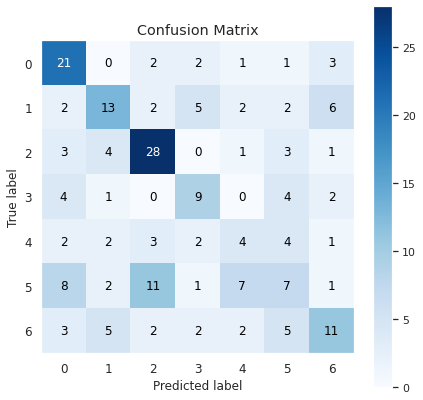

In [ ]:
yp_val = cnn41.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn12.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

### CNN-42 Two additional blocks

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn42'
if del_var in globals(): globals().pop(del_var, None)

cnn42 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                    
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn42.build(X_train_bal.shape)
# Check network
cnn42.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (1596, 46, 46, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (1596, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_15 (Activation)  (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (1596, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (1596, 21, 21, 64)        18496     
                                                                 
 activation_16 (Activation)  (1596, 21, 21, 64)       

In [ ]:
learning_rate = 0.001
cnn42.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history42 = cnn42.fit(X_train_bal, y_train_bal, batch_size=64,epochs=50, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

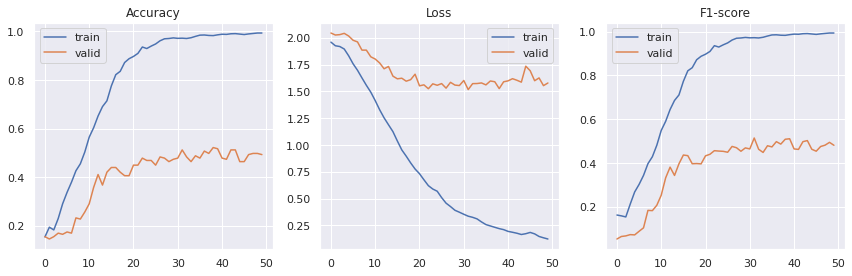

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history42.epoch, history42.history['accuracy'], label='train')
sns.lineplot(history42.epoch, history42.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history42.epoch, history42.history['loss'], label='train')
sns.lineplot(history42.epoch, history42.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history42.epoch, history42.history['f1_score'], label='train')
sns.lineplot(history42.epoch, history42.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 4ms/step
val accuracy: 49.2754 %


              precision    recall  f1-score   support

           0       0.71      0.67      0.69        30
           1       0.38      0.34      0.36        32
           2       0.72      0.65      0.68        40
           3       0.54      0.35      0.42        20
           4       0.33      0.39      0.36        18
           5       0.36      0.43      0.39        37
           6       0.43      0.50      0.46        30

    accuracy                           0.49       207
   macro avg       0.50      0.48      0.48       207
weighted avg       0.51      0.49      0.50       207



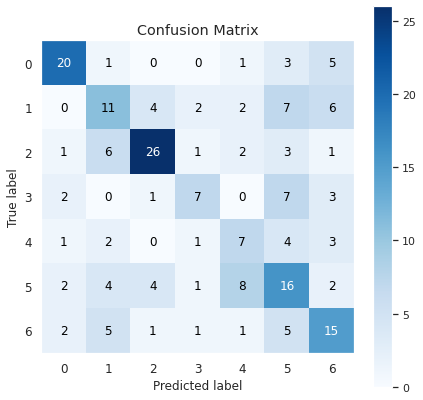

In [ ]:
yp_val = cnn42.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn12.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

## Iteration 5 - Try batch Normalization 

### CNN-51

#### 50 epochs, 64 batch-size

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn51'
if del_var in globals(): globals().pop(del_var, None)

cnn51 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.BatchNormalization(), 
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(), 
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                    
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(), 
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(), 
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(), 
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn51.build(X_train_bal.shape)
# Check network
cnn51.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (1596, 48, 48, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_19 (Conv2D)          (1596, 46, 46, 32)        896       
                                                                 
 batch_normalization_9 (Batc  (1596, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_19 (Activation)  (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (1596, 23, 23, 32)       0         
 g2D)                                                            
                                                      

In [ ]:
learning_rate = 0.001
cnn51.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history51 = cnn51.fit(X_train_bal, y_train_bal, batch_size=64,epochs=50, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

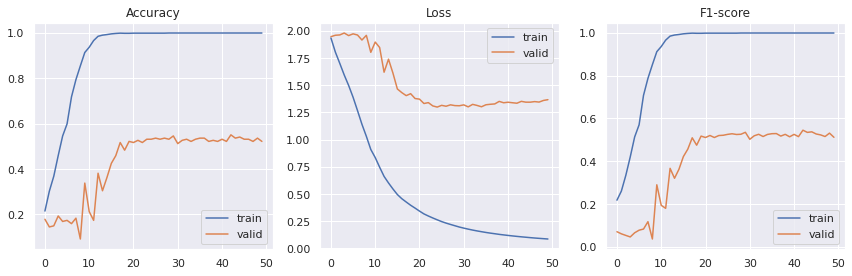

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history51.epoch, history51.history['accuracy'], label='train')
sns.lineplot(history51.epoch, history51.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history51.epoch, history51.history['loss'], label='train')
sns.lineplot(history51.epoch, history51.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history51.epoch, history51.history['f1_score'], label='train')
sns.lineplot(history51.epoch, history51.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 4ms/step
val accuracy: 52.1739 %


              precision    recall  f1-score   support

           0       0.51      0.63      0.57        30
           1       0.46      0.41      0.43        32
           2       0.68      0.68      0.68        40
           3       0.53      0.40      0.46        20
           4       0.50      0.56      0.53        18
           5       0.52      0.43      0.47        37
           6       0.42      0.50      0.45        30

    accuracy                           0.52       207
   macro avg       0.52      0.51      0.51       207
weighted avg       0.52      0.52      0.52       207



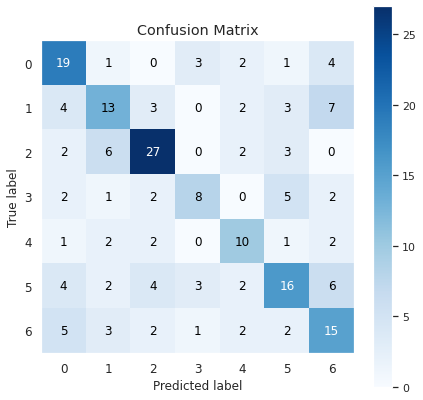

In [ ]:
yp_val = cnn51.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn53.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

#### 20 epochs, 64 batch-size

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn51'
if del_var in globals(): globals().pop(del_var, None)

cnn51 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.BatchNormalization(), 
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(), 
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                    
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(), 
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(), 
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(), 
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn51.build(X_train_bal.shape)
# Check network
cnn51.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_45 (Bat  (1596, 48, 48, 3)        12        
 chNormalization)                                                
                                                                 
 conv2d_38 (Conv2D)          (1596, 46, 46, 32)        896       
                                                                 
 batch_normalization_46 (Bat  (1596, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 activation_38 (Activation)  (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_37 (MaxPoolin  (1596, 23, 23, 32)       0         
 g2D)                                                            
                                                      

In [ ]:
learning_rate = 0.001
cnn51.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history51 = cnn51.fit(X_train_bal, y_train_bal, batch_size=64,epochs=20, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

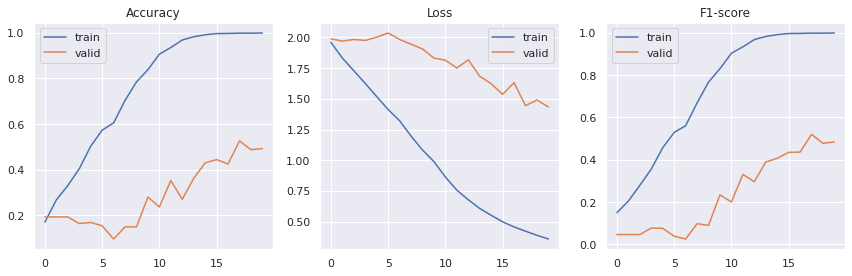

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history51.epoch, history51.history['accuracy'], label='train')
sns.lineplot(history51.epoch, history51.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history51.epoch, history51.history['loss'], label='train')
sns.lineplot(history51.epoch, history51.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history51.epoch, history51.history['f1_score'], label='train')
sns.lineplot(history51.epoch, history51.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 4ms/step
val accuracy: 49.2754 %


              precision    recall  f1-score   support

           0       0.68      0.57      0.62        30
           1       0.36      0.44      0.39        32
           2       0.71      0.55      0.62        40
           3       0.27      0.30      0.29        20
           4       0.40      0.56      0.47        18
           5       0.67      0.49      0.56        37
           6       0.39      0.50      0.44        30

    accuracy                           0.49       207
   macro avg       0.50      0.49      0.48       207
weighted avg       0.53      0.49      0.50       207



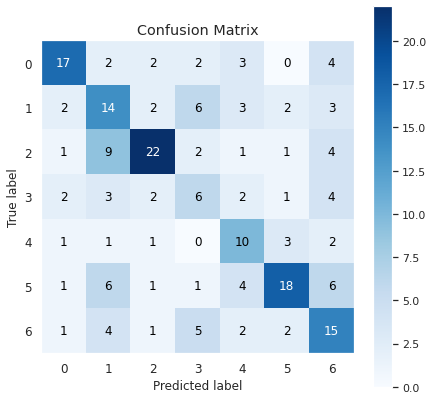

In [ ]:
yp_val = cnn51.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn51.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

**Apply the CNN51 model to the test dataset**

8/8 [==============================] - 0s 4ms/step
test accuracy: 54.5082 %


              precision    recall  f1-score   support

           0       0.69      0.51      0.59        35
           1       0.51      0.58      0.54        38
           2       0.71      0.62      0.66        47
           3       0.33      0.54      0.41        24
           4       0.53      0.43      0.47        21
           5       0.65      0.55      0.59        44
           6       0.44      0.51      0.47        35

    accuracy                           0.55       244
   macro avg       0.55      0.53      0.54       244
weighted avg       0.57      0.55      0.55       244



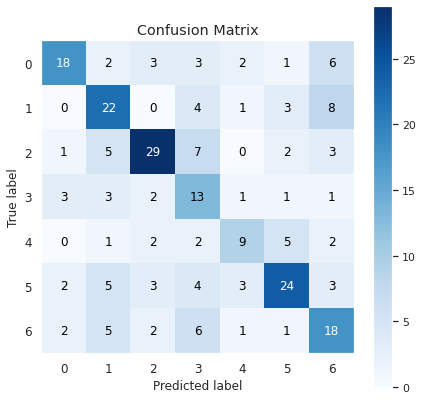

In [ ]:
yp_test = cnn51.predict(X_test)
yp_test = np.argmax(yp_test, axis=1)
ytest = np.argmax(y_test, axis=1)

skplt.metrics.plot_confusion_matrix(ytest, yp_test, figsize=(7,7))
plt.savefig("confusion_matrix_cnn51.png")

test_accu = np.sum(ytest == yp_test) / len(ytest) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest, yp_test))

**Tensorboard**

In [ ]:
!tensorboard dev upload --logdir logs --name "Models DLNN - CNN51" --description "Models DLNN - CNN51"

Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Irk4O5tAQWOoUobIgzuWtA/

[2023-02-04T16:58:39] Started scanning logdir.
[2023-02-04T17:00:24] Total uploaded: 4320 scalars, 69520 tensors (48.8 MB), 0 binary objects
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.8/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.8/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.8/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.8/dist-packages/tensorboard/program.py", line 276, in main
    return runner(self.flags) or 0
  File "/usr/local/l

## Iteration 6 - Try regularization

### CNN-61 (1 Dropout e L2)

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn61'
if del_var in globals(): globals().pop(del_var, None)

cnn61 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.BatchNormalization(), 
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(), 
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                    
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn61.build(X_train_bal.shape)
# Check network
cnn61.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (1596, 48, 48, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (1596, 46, 46, 32)        896       
                                                                 
 batch_normalization_1 (Batc  (1596, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (1596, 23, 23, 32)       0         
 )                                                               
                                                        

In [ ]:
learning_rate = 0.001
cnn61.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history61 = cnn61.fit(X_train_bal, y_train_bal, batch_size=64,epochs=20, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

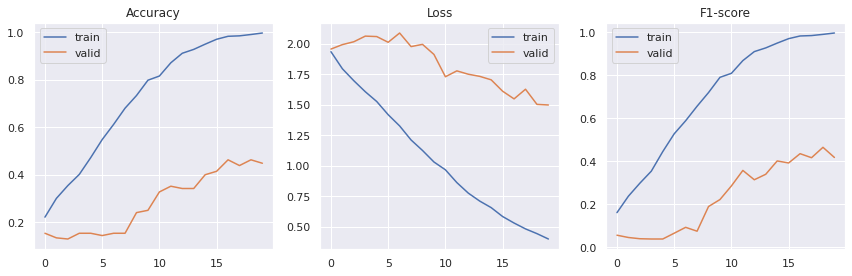

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history61.epoch, history61.history['accuracy'], label='train')
sns.lineplot(history61.epoch, history61.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history61.epoch, history61.history['loss'], label='train')
sns.lineplot(history61.epoch, history61.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history61.epoch, history61.history['f1_score'], label='train')
sns.lineplot(history61.epoch, history61.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 27ms/step
val accuracy: 44.9275 %


              precision    recall  f1-score   support

           0       0.54      0.47      0.50        30
           1       0.71      0.16      0.26        32
           2       0.74      0.65      0.69        40
           3       0.38      0.15      0.21        20
           4       0.41      0.39      0.40        18
           5       0.56      0.41      0.47        37
           6       0.26      0.77      0.39        30

    accuracy                           0.45       207
   macro avg       0.51      0.43      0.42       207
weighted avg       0.54      0.45      0.44       207



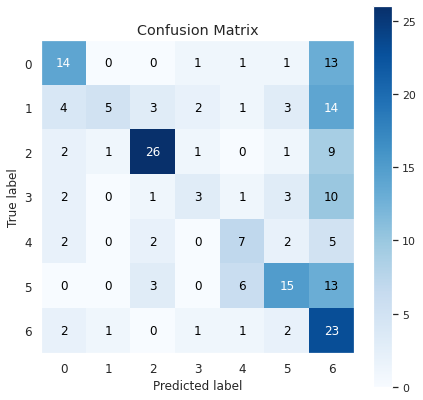

In [ ]:
yp_val = cnn61.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn61.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

### CNN-61 (2 dropout e L2)

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn61'
if del_var in globals(): globals().pop(del_var, None)

cnn61 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.BatchNormalization(), 
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.Dropout(0.3),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                    
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn61.build(X_train_bal.shape)
# Check network
cnn61.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_21 (Bat  (1596, 48, 48, 3)        12        
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (1596, 46, 46, 32)        896       
                                                                 
 batch_normalization_22 (Bat  (1596, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (1596, 46, 46, 32)        0         
                                                                 
 dropout_10 (Dropout)        (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (1596, 23, 23, 32)      

In [ ]:
learning_rate = 0.001
cnn61.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history61 = cnn61.fit(X_train_bal, y_train_bal, batch_size=64,epochs=20, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

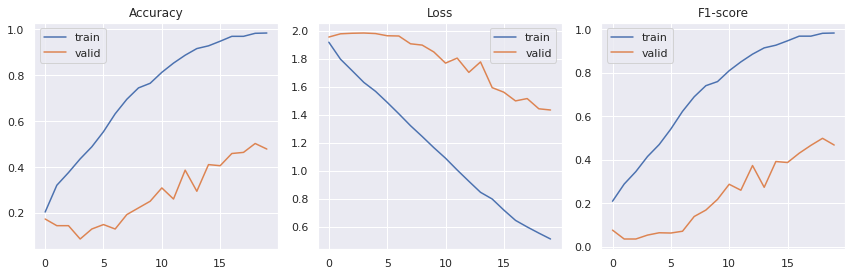

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history61.epoch, history61.history['accuracy'], label='train')
sns.lineplot(history61.epoch, history61.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history61.epoch, history61.history['loss'], label='train')
sns.lineplot(history61.epoch, history61.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history61.epoch, history61.history['f1_score'], label='train')
sns.lineplot(history61.epoch, history61.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 24ms/step
val accuracy: 47.8261 %


              precision    recall  f1-score   support

           0       0.94      0.53      0.68        30
           1       0.37      0.47      0.41        32
           2       0.69      0.60      0.64        40
           3       0.46      0.30      0.36        20
           4       0.40      0.44      0.42        18
           5       0.34      0.62      0.44        37
           6       0.50      0.23      0.32        30

    accuracy                           0.48       207
   macro avg       0.53      0.46      0.47       207
weighted avg       0.54      0.48      0.48       207



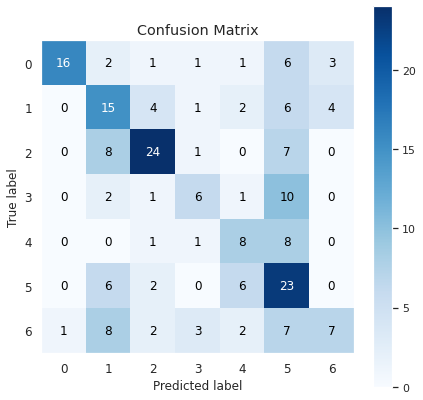

In [ ]:
yp_val = cnn61.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn61.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

### CNN-61 (3 dropout e L2)

In [ ]:
#Delete cnn object if it exists
del_var = 'cnn61'
if del_var in globals(): globals().pop(del_var, None)

cnn61 = Sequential([# Feature extraction
                   #layers.Input(input_shape[1:]),
                   layers.BatchNormalization(), 
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.Dropout(0.3),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                    
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.Dropout(0.3),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification (use units=n_classes, activation="softmax" for multi-class problems)
                   layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=len(y_train_bal[0]), activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn61.build(X_train_bal.shape)
# Check network
cnn61.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_10 (Bat  (1596, 48, 48, 3)        12        
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (1596, 46, 46, 32)        896       
                                                                 
 batch_normalization_11 (Bat  (1596, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (1596, 46, 46, 32)        0         
                                                                 
 dropout_3 (Dropout)         (1596, 46, 46, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (1596, 23, 23, 32)      

In [ ]:
learning_rate = 0.001
cnn61.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[
                      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC'),
                      f1])

In [ ]:
history61 = cnn61.fit(X_train_bal, y_train_bal, batch_size=64,epochs=20, shuffle=True, 
                      validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

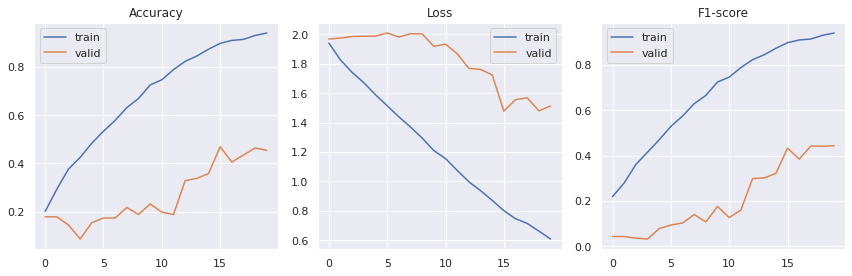

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history61.epoch, history61.history['accuracy'], label='train')
sns.lineplot(history61.epoch, history61.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history61.epoch, history61.history['loss'], label='train')
sns.lineplot(history61.epoch, history61.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history61.epoch, history61.history['f1_score'], label='train')
sns.lineplot(history61.epoch, history61.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 0s 29ms/step
val accuracy: 45.4106 %


              precision    recall  f1-score   support

           0       0.79      0.50      0.61        30
           1       0.26      0.69      0.37        32
           2       0.57      0.68      0.62        40
           3       0.31      0.20      0.24        20
           4       0.60      0.50      0.55        18
           5       0.61      0.30      0.40        37
           6       0.67      0.20      0.31        30

    accuracy                           0.45       207
   macro avg       0.54      0.44      0.44       207
weighted avg       0.55      0.45      0.45       207



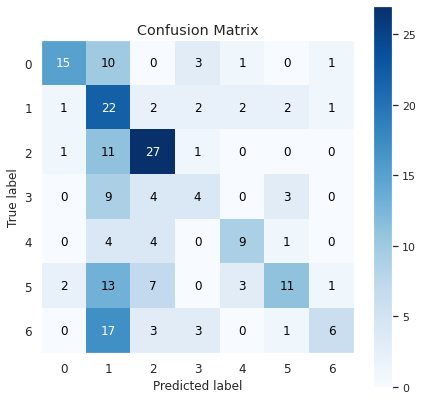

In [ ]:
yp_val = cnn61.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_cnn61.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

# Transfer Learning (rational to use)

Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.

At the figure below we can see a sample of the different architectures available. They differ on the:

1. the top-1 and top-5 accuracy, which refer to the model's performance on the ImageNet validation dataset;
2. depth that refers to the topological depth of the network (e.g. activation layers, batch normalization layers,...). 

*Observation*: Depth counts the number of layers with parameters;
time per inference step is the average of 30 batches and 10 repetitions. The batch size used was 32.

[Source: Keras Applications](https://keras.io/api/applications/)

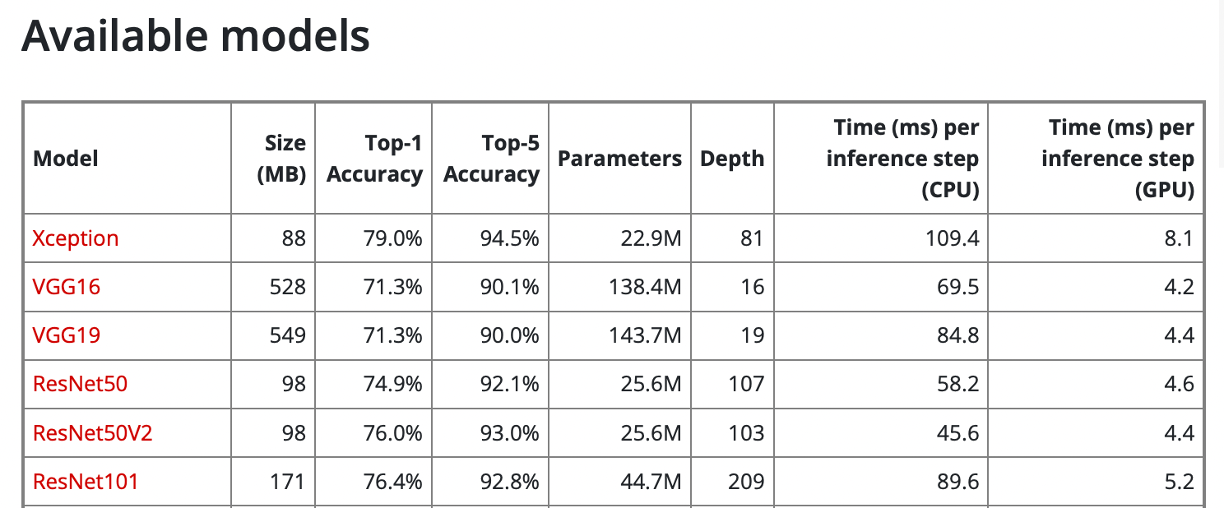

**What is ImageNet?**

ImageNet is an image dataset organized according to the WordNet hierarchy. Each meaningful concept in WordNet, possibly described by multiple words or word phrases, is called a "synonym set" or "synset". In ImageNet, we aim to provide on average 1000 images to illustrate each synset. Images of each concept are quality-controlled and human-annotated. In its completion ImageNet will offer tens of millions of cleanly labeled and sorted images for most of the concepts in the WordNet hierarchy.

[Source: ImageNet](https://www.image-net.org/about.php)

**Why will we use Transfer Learning?**

Since we have a relatively small dataset, even after performing data augmentation, our training set will not have as much data as we would like.

Therefore we intend to compare the results of training a full model from scratch with the results of training a model that uses the weights trained on ImageNet dataset.

We will use ResNet-50 model since it has a good model's performance on ImageNet dataset, a relatively low time per inference step and a low size.

## Iteration 1 (using cnn51 classifier architecture | batch_size 64 | epochs 200)

**Initialize the Pretrained Model ResNet-50**

In [ ]:
del_var = 'TL_base_model_1'
if del_var in globals(): globals().pop(del_var, None)

TL_base_model_1 = tf.keras.applications.ResNet50(
    include_top=False,                #Do not include the ImageNet classifier at the top
    weights="imagenet",               #Load weights pre-trained on ImageNet dataset
    input_shape=X_train_bal[0].shape # 3 inputs channels and width and height > 32. E.g. (200, 200, 3)
          )

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
TL_base_model_1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

**Freeze the base model to make sure it's not being trained**

Freeze all layers in the base model by setting trainable = False. With this step we avoid destroying any of the information they contain during future training rounds.

In [ ]:
TL_base_model_1.trainable = False

**Create the input and change the final linear layer of ResNet-50.**

In [ ]:
# Create a new model on top
input_ = keras.Input(shape=X_train_bal[0].shape) 

# Set the model to inference mode: the batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.
x = TL_base_model_1(input_, training=False) 

# Set the pooling layer - Obtain a vector of pooled features per image
x = keras.layers.GlobalMaxPooling2D()(x) 

# A Dense classifier with a softmax activation function (ensures the output values are in the range of 0 and 1 and may be used as predicted prob)
x = keras.layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))(x)

output_ = keras.layers.Dense(units=len(y_train_bal[0]), 
                       activation="softmax",
                       kernel_initializer=initializers.GlorotNormal(seed=seed))(x) #grab the characteristics of the last dense

# Create instance of Model
model_TL_1 = Model(input_, output_)

# Compile the model
learning_rate = 0.001
model_TL_1.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.Adam(learning_rate=learning_rate),  
                 metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC'),
                          f1])

# Print The Summary of The Model
model_TL_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
 dense_1 (Dense)             (None, 7)                 77        
                                                                 
Total params: 23,608,279
Trainable params: 20,567
Non-trainable params: 23,587,712
____________________________________________

**Train the model and visualize the outputs**

In [ ]:
epochs = 200
batch_size = 64 

#model training
history_TL_1 = model_TL_1.fit(X_train_bal, y_train_bal, batch_size = batch_size, epochs=epochs, shuffle=True, 
                    validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

In [ ]:
#Access history dictionary
df_hist_TL_1 = pd.DataFrame.from_dict(history_TL_1.history)
df_hist_TL_1["Epoch"] = np.arange(1, len(df_hist_TL_1) + 1, 1)

**Visualize loss and F1 curves**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

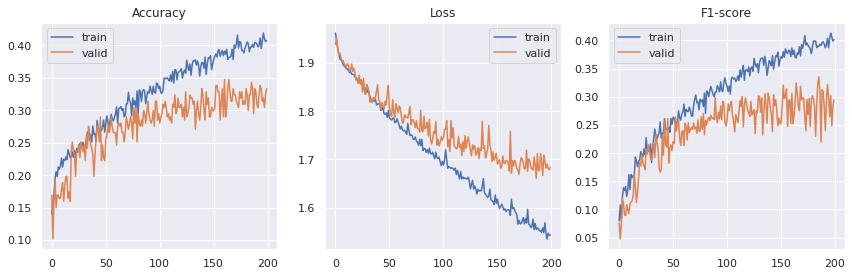

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history_TL_1.epoch, history_TL_1.history['accuracy'], label='train')
sns.lineplot(history_TL_1.epoch, history_TL_1.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history_TL_1.epoch, history_TL_1.history['loss'], label='train')
sns.lineplot(history_TL_1.epoch, history_TL_1.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history_TL_1.epoch, history_TL_1.history['f1_score'], label='train')
sns.lineplot(history_TL_1.epoch, history_TL_1.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

7/7 [==============================] - 4s 411ms/step
val accuracy: 32.8502 %


              precision    recall  f1-score   support

           0       0.46      0.63      0.54        30
           1       0.13      0.06      0.09        32
           2       0.42      0.45      0.43        40
           3       0.14      0.05      0.07        20
           4       0.35      0.33      0.34        18
           5       0.35      0.30      0.32        37
           6       0.21      0.37      0.27        30

    accuracy                           0.33       207
   macro avg       0.30      0.31      0.29       207
weighted avg       0.31      0.33      0.31       207



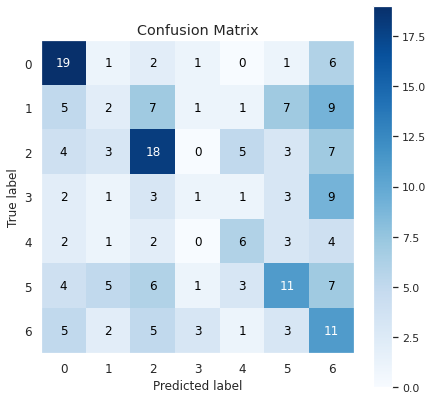

In [ ]:
yp_val = model_TL_1.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_model_TL.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

## Iteration 2 (using cnn51 classifier architecture | batch_size 128 | epochs 200)

In [ ]:
del_var = 'TL_base_model_2'
if del_var in globals(): globals().pop(del_var, None)

TL_base_model_2 = tf.keras.applications.ResNet50(
    include_top=False,                #Do not include the ImageNet classifier at the top
    weights="imagenet",               #Load weights pre-trained on ImageNet dataset
    input_shape=X_train_bal[0].shape  #3 inputs channels and width and height > 32. E.g. (200, 200, 3)
            )

In [ ]:
TL_base_model_2.trainable = False

In [ ]:
# Create a new model on top
input_ = keras.Input(shape=X_train_bal[0].shape) 

# Set the model to inference mode: the batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.
x = TL_base_model_2(input_, training=False) 

# Set the pooling layer - Obtain a vector of pooled features per image
x = keras.layers.GlobalMaxPooling2D()(x) 

# A Dense classifier with a softmax activation function (ensures the output values are in the range of 0 and 1 and may be used as predicted prob)
x = keras.layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
output_ = keras.layers.Dense(units=len(y_train_bal[0]), 
                       activation="softmax",
                       kernel_initializer=initializers.GlorotNormal(seed=seed))(x) #grab the characteristics of the last dense

# Create instance of Model
model_TL_2 = Model(input_, output_)

# Compile the model
learning_rate = 0.001
model_TL_2.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.Adam(learning_rate=learning_rate),  
                 metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC'),
                          f1])

# Print The Summary of The Model
model_TL_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                20490     
                                                                 
 dense_3 (Dense)             (None, 7)                 77        
                                                                 
Total params: 23,608,279
Trainable params: 20,567
Non-trainable params: 23,587,712
__________________________________________

In [ ]:
epochs = 200
batch_size = 128 #batch_size 128 revelead better results than the ones using the default value and 64

#model training
history_TL_2 = model_TL_2.fit(X_train_bal, y_train_bal, batch_size = batch_size, epochs=epochs, shuffle=True, 
                    validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

In [ ]:
#Access history dictionary
df_hist_TL_2 = pd.DataFrame.from_dict(history_TL_2.history)
df_hist_TL_2["Epoch"] = np.arange(1, len(df_hist_TL_2) + 1, 1)

**Visualize loss and F1 curves**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

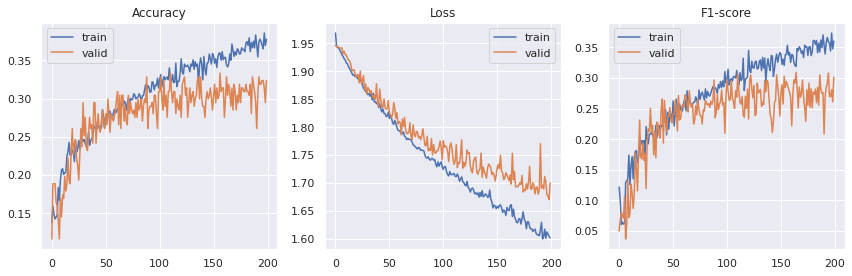

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history_TL_2.epoch, history_TL_2.history['accuracy'], label='train')
sns.lineplot(history_TL_2.epoch, history_TL_2.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history_TL_2.epoch, history_TL_2.history['loss'], label='train')
sns.lineplot(history_TL_2.epoch, history_TL_2.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history_TL_2.epoch, history_TL_2.history['f1_score'], label='train')
sns.lineplot(history_TL_2.epoch, history_TL_2.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

**Confusion matrixes**

7/7 [==============================] - 2s 14ms/step
val accuracy: 32.3671 %


              precision    recall  f1-score   support

           0       0.58      0.63      0.60        30
           1       0.25      0.03      0.06        32
           2       0.39      0.38      0.38        40
           3       0.16      0.20      0.18        20
           4       0.50      0.22      0.31        18
           5       0.38      0.24      0.30        37
           6       0.20      0.50      0.29        30

    accuracy                           0.32       207
   macro avg       0.35      0.32      0.30       207
weighted avg       0.35      0.32      0.31       207



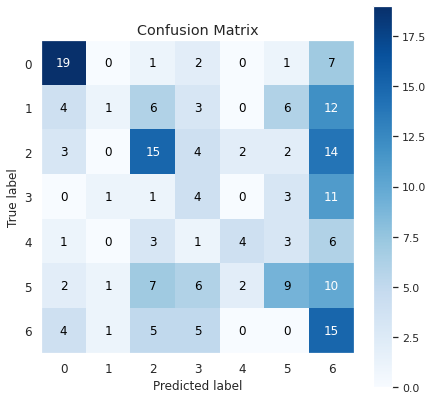

In [ ]:
yp_val = model_TL_2.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_model_TL.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

## Iteration 3 (using a more complex classifier architecture | batch_size 128 | epochs 200)

In [ ]:
del_var = 'TL_base_model_3'
if del_var in globals(): globals().pop(del_var, None)

TL_base_model_3 = tf.keras.applications.ResNet50(
    include_top=False,               #Do not include the ImageNet classifier at the top
    weights="imagenet",              #Load weights pre-trained on ImageNet dataset
    input_shape=X_train_bal[0].shape # 3 inputs channels and width and height > 32. E.g. (200, 200, 3)
              )

In [ ]:
TL_base_model_3.trainable = False

In [ ]:
# Create a new model on top
input_ = keras.Input(shape=X_train_bal[0].shape) 

# Set the model to inference mode: the batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.
x = TL_base_model_3(input_, training=False) 

# Set the pooling layer - Obtain a vector of pooled features per image
x = keras.layers.GlobalMaxPooling2D()(x) 

# A Dense classifier with a softmax activation function (ensures the output values are in the range of 0 and 1 and may be used as predicted prob)
x = keras.layers.Dense(units=128, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
output_ = keras.layers.Dense(units=len(y_train_bal[0]), 
                       activation="softmax",
                       kernel_initializer=initializers.GlorotNormal(seed=seed))(x) #grab the characteristics of the last dense

# Create instance of Model
model_TL_3 = Model(input_, output_)

# Compile the model
learning_rate = 0.001
model_TL_3.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.Adam(learning_rate=learning_rate),  
                 metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC'),
                          f1])

# Print The Summary of The Model
model_TL_3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d_7 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_21 (Dense)            (None, 128)               262272    
                                                                 
 dense_22 (Dense)            (None, 7)                 903       
                                                                 
Total params: 23,850,887
Trainable params: 263,175
Non-trainable params: 23,587,712
_________________________________________

In [ ]:
epochs = 200
batch_size = 128 

#model training
history_TL_3 = model_TL_3.fit(X_train_bal, y_train_bal, batch_size = batch_size, epochs=epochs, shuffle=True, 
                    validation_data=(X_val, y_val), verbose=0)#, callbacks=[tensorboard_callback])

In [ ]:
#Access history dictionary
df_hist_TL_3 = pd.DataFrame.from_dict(history_TL_3.history)
df_hist_TL_3["Epoch"] = np.arange(1, len(df_hist_TL_3) + 1, 1)

**Visualize loss and F1 curves**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

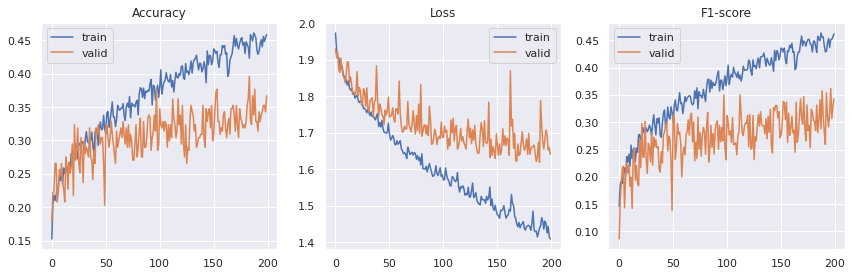

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 3, 1)
sns.lineplot(history_TL_3.epoch, history_TL_3.history['accuracy'], label='train')
sns.lineplot(history_TL_3.epoch, history_TL_3.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
sns.lineplot(history_TL_3.epoch, history_TL_3.history['loss'], label='train')
sns.lineplot(history_TL_3.epoch, history_TL_3.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
sns.lineplot(history_TL_3.epoch, history_TL_3.history['f1_score'], label='train')
sns.lineplot(history_TL_3.epoch, history_TL_3.history['val_f1_score'], label='valid')
plt.title('F1-score')
plt.tight_layout()

plt.savefig('epoch_history.png')
plt.show()

**Confusion matrixes**

7/7 [==============================] - 1s 26ms/step
val accuracy: 36.715 %


              precision    recall  f1-score   support

           0       0.51      0.77      0.61        30
           1       0.30      0.22      0.25        32
           2       0.46      0.42      0.44        40
           3       0.40      0.10      0.16        20
           4       0.45      0.28      0.34        18
           5       0.45      0.24      0.32        37
           6       0.20      0.43      0.27        30

    accuracy                           0.37       207
   macro avg       0.40      0.35      0.34       207
weighted avg       0.40      0.37      0.35       207



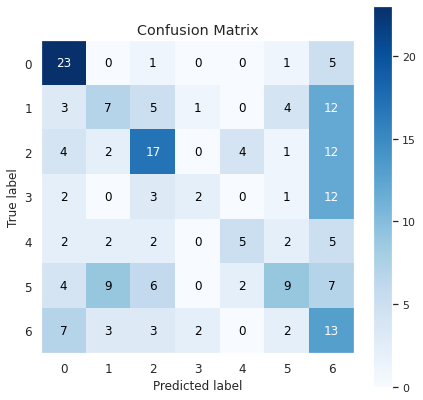

In [ ]:
yp_val = model_TL_3.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_model_TL.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

## Final model (Iteration 2 configuration with 100 epochs)

In [ ]:
del_var = 'TL_base_model_f'
if del_var in globals(): globals().pop(del_var, None)

TL_base_model_f = tf.keras.applications.ResNet50(
    include_top=False,                #Do not include the ImageNet classifier at the top
    weights="imagenet",               #Load weights pre-trained on ImageNet dataset
    input_shape=X_train_bal[0].shape  #3 inputs channels and width and height > 32. E.g. (200, 200, 3)
            )

In [ ]:
TL_base_model_f.trainable = False

In [ ]:
# Create a new model on top
input_ = keras.Input(shape=X_train_bal[0].shape) 

# Set the model to inference mode: the batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.
x = TL_base_model_f(input_, training=False) 

# Set the pooling layer - Obtain a vector of pooled features per image
x = keras.layers.GlobalMaxPooling2D()(x) 

# A Dense classifier with a softmax activation function (ensures the output values are in the range of 0 and 1 and may be used as predicted prob)
x = keras.layers.Dense(units=10, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
output_ = keras.layers.Dense(units=len(y_train_bal[0]), 
                       activation="softmax",
                       kernel_initializer=initializers.GlorotNormal(seed=seed))(x) #grab the characteristics of the last dense

# Create instance of Model
model_TL_f = Model(input_, output_)

# Compile the model
learning_rate = 0.001
model_TL_f.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.Adam(learning_rate=learning_rate),  
                 metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC'),
                          f1])

# Print The Summary of The Model
model_TL_f.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d_6 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_11 (Dense)            (None, 10)                20490     
                                                                 
 dense_12 (Dense)            (None, 7)                 77        
                                                                 
Total params: 23,608,279
Trainable params: 20,567
Non-trainable params: 23,587,712
__________________________________________

In [ ]:
epochs = 100
batch_size = 128

#model training
history_TL_f = model_TL_f.fit(X_train_bal, y_train_bal, batch_size = batch_size, epochs=epochs, shuffle=True, 
                    validation_data=(X_val, y_val), verbose=0, callbacks=[tensorboard_callback])

In [ ]:
#Access history dictionary
df_hist_TL_f = pd.DataFrame.from_dict(history_TL_f.history)
df_hist_TL_f["Epoch"] = np.arange(1, len(df_hist_TL_f) + 1, 1)

**Confusion matrixes**

7/7 [==============================] - 0s 25ms/step
val accuracy: 29.9517 %


              precision    recall  f1-score   support

           0       0.54      0.47      0.50        30
           1       0.29      0.12      0.17        32
           2       0.39      0.38      0.38        40
           3       0.00      0.00      0.00        20
           4       0.25      0.22      0.24        18
           5       0.60      0.08      0.14        37
           6       0.21      0.73      0.32        30

    accuracy                           0.30       207
   macro avg       0.32      0.29      0.25       207
weighted avg       0.36      0.30      0.27       207



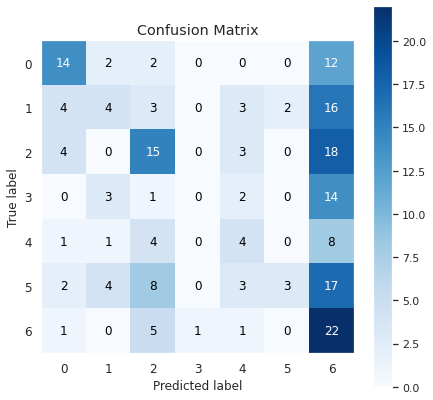

In [ ]:
yp_val = model_TL_f.predict(X_val)
yp_val = np.argmax(yp_val, axis=1)
yval = np.argmax(y_val, axis=1)

skplt.metrics.plot_confusion_matrix(yval, yp_val, figsize=(7,7))
plt.savefig("confusion_matrix_model_TL.png")

val_accu = np.sum(yval == yp_val) / len(yval) * 100
print(f"val accuracy: {round(val_accu, 4)} %\n\n")

print(classification_report(yval, yp_val))

**Apply the final transfer learning model to the test dataset**

8/8 [==============================] - 0s 26ms/step
test accuracy: 30.7377 %


              precision    recall  f1-score   support

           0       0.56      0.43      0.48        35
           1       0.29      0.11      0.15        38
           2       0.40      0.40      0.40        47
           3       0.00      0.00      0.00        24
           4       0.40      0.48      0.43        21
           5       0.11      0.02      0.04        44
           6       0.22      0.74      0.34        35

    accuracy                           0.31       244
   macro avg       0.28      0.31      0.26       244
weighted avg       0.29      0.31      0.26       244



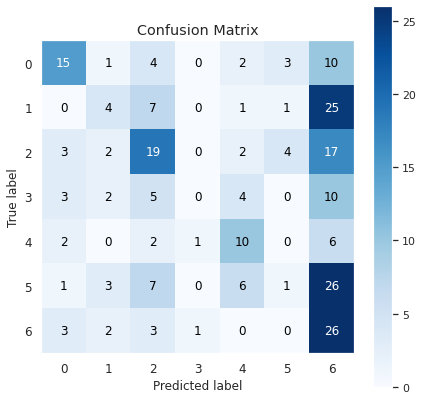

In [ ]:
yp_test = model_TL_f.predict(X_test)
yp_test = np.argmax(yp_test, axis=1)
ytest = np.argmax(y_test, axis=1)

skplt.metrics.plot_confusion_matrix(ytest, yp_test, figsize=(7,7))
plt.savefig("confusion_matrix_TL.png")

test_accu = np.sum(ytest == yp_test) / len(ytest) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest, yp_test))

**TensorBoard**

In [ ]:
!tensorboard dev upload --logdir logs --name "Models DLNN ResNet50" --description "Models DLNN ResNet50"


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=HeFP9zKk2FtjBpiVvUD05TFmd2fPe7&prompt=consent&access_type=offline
Enter th

# Heat Maps using ResNet50 model

**Create a function that will return the heatmap and the transformed image**

In [ ]:
def heatmaps_resnet50 (img_path):
  res_model = ResNet50(weights = 'imagenet')
  
  img_resnet = cv2.imread(img_path)                         #loads an image from the specified fil
  img_resnet = cv2.resize(img_resnet, (224,224))            #Resizing an image = changing the dimensions of it. The aspect ratio of the original image could be preserved in the resized image.
  img_resnet = cv2.cvtColor(img_resnet, cv2.COLOR_BGR2RGB)  #convert an image from one color space to another (convert between RGB/BGR and grayscale) -- esta linha é necessária?
  X = np.expand_dims(img_resnet, axis=0).astype(np.float32) #Expand the shape of an array.
  X = preprocess_input(X)                                   #Preprocesses a tensor or Numpy array encoding a batch of images.

  conv_output_resnet = res_model.get_layer("conv5_block3_out").output #get the Output of last convultional layer #model_TL.layers[1].layers[-1].output 
  pred_output_resnet = res_model.get_layer("predictions").output      #get the output of the dense layer #model_TL.layers[-1].output

  model_resnet50 = Model(res_model.input, outputs=[conv_output_resnet, pred_output_resnet]) #Group the layers into an object with training and inference features.

  conv_resnet, pred_resnet = model_resnet50.predict(X) #Make a prediction using the transformed image
  #decode_resnet = decode_predictions(pred_resnet)
  
  target = np.argmax(pred_resnet, axis=1).squeeze() #argmax returns the indices of the maximum values along an axis.
                                                    #squeeze is the inverse operation of expand_dims, it removes singleton dimensions
  w, b = model_resnet50.get_layer("predictions").weights
  weights_resnet = w[:, target].numpy()
  heatmap_resnet = conv_resnet.squeeze() @ weights_resnet
  
  return img_resnet, heatmap_resnet


**Select 8 figures, one for each emotion and the last one being an augmented picture**

In [ ]:
pics_list = [folder_input + 'TRAIN_augmentation/anger/TRAIN_664.jpeg', 
             folder_input + 'TRAIN_augmentation/disgust/TRAIN_160.jpeg', 
             folder_input + 'TRAIN_augmentation/fear/TRAIN_117.jpeg', 
             folder_input + 'TRAIN_augmentation/happy/TRAIN_356.jpeg', 
             folder_input + 'TRAIN_augmentation/neutral/TRAIN_1095.jpeg', 
             folder_input + 'TRAIN_augmentation/sadness/TRAIN_776.jpeg', 
             folder_input + 'TEST/surprise/TEST_180.jpeg', 
             folder_input + 'TRAIN_augmentation/surprise/aug_img_15.jpeg']


**Show the heatmap with the ground pictures**

1/1 [==============================] - 1s 1s/step


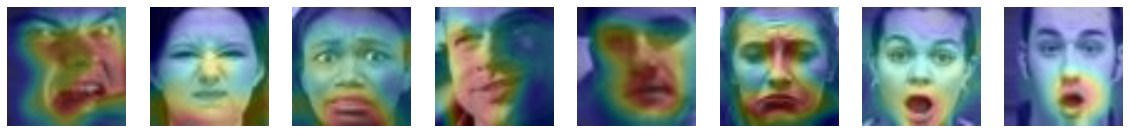

In [ ]:
scale_resnet = 224 / 7
plt.figure(figsize=(20, 3))
i=0
for pic in pics_list:
  heatmap = heatmaps_resnet50(pic)
  plt.subplot(1, 8, i + 1)
  plt.imshow(heatmap[0])
  plt.imshow(zoom(heatmap[1], zoom=(scale_resnet, scale_resnet)), cmap='jet', alpha=0.3)
  plt.axis('off')
  i+=1